## Setting up the google colab (optional)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install numpy
!pip install pandas
!pip install scanpy
!pip install scanpy.external
!pip install harmonypy
!pip install seaborn
!pip install mudata
!pip install muon
!pip install mudatasets

## Importing the necessary packages 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import mudata as md
import muon as mu
import mudatasets as mds
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy.external as sce
from scipy import stats
from Bio import SeqIO
from matplotlib.pyplot import rc_context
import anndata as ad
import warnings
import sccoda.util
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

import sccoda.datasets as scd

warnings.filterwarnings("ignore")

2023-10-27 09:26:28.382806: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-27 09:26:28.384469: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-27 09:26:28.421199: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-27 09:26:28.421986: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-27 09:26:29.007521: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
sc.settings.verbosity = 4
sc.logging.print_header()
sc.settings.set_figure_params(dpi=300, facecolor='white', format = 'pdf', vector_friendly = True)

scanpy==1.9.1 anndata==0.8.0 umap==0.5.2 numpy==1.22.4 scipy==1.10.1 pandas==1.4.3 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.10.4 louvain==0.7.1 pynndescent==0.5.6


In [3]:
umap_cmap = sns.blend_palette(['lightgrey', 'xkcd:sapphire'], as_cmap = True)

## Read processed file from previous notebooks 

In [4]:
#Processed
mdata = mu.read("/mnt/sda/david/hydractinia/hydractinia_atlas_colored_20230825.h5mu")
adata= (mdata.mod['no'])

In [5]:
adata

AnnData object with n_obs × n_vars = 199113 × 18061
    obs: 'Experiment', 'Library', 'Body_part', 'Presence_of_PEG', 'batch', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_1', 'leiden_1.5', 'leiden_2', 'Colony_part', 'Unique', 'leiden_1.5_names', 'broad_names'
    var: 'ratio_with_no', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Colony_part_colors', 'Library_colors', 'broad_names_colors', 'dendrogram_leiden_1.5', 'hvg', 'leiden', 'leiden_1.5_colors', 'leiden_1.5_colors_sorted', 'leiden_1.5_sorted', 'leiden_1_colors', 'leiden_2_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups_logreg_leiden_1', 'rank_genes_groups_logreg_leiden_1.5', 'rank_genes_groups_logreg_leiden_2', 'rank_genes_groups_wilcox_leiden_1', 'rank_genes_groups_wilcox_leiden_1.5', 'rank_genes_groups_wilcox_leiden_2', 'umap'
    obsm: '

### <u>From the documentation page of scCODA:<u>

  #### Model properties

    First, the summary shows an overview over the model properties: 
    * Number of samples/cell types 
    * The reference cell type 
    * The formula used

    The model has two types of parameters that are relevant for analysis - intercepts and effects. These can be interpreted like in a standard regression model: Intercepts show how the cell types are distributed without any active covariates, effects show ho the covariates influence the cell types.

   
  #### Intercepts

    The first column of the intercept summary shows the parameters determined by the MCMC inference.

    The “Expected sample” column gives some context to the numerical values. If we had a new sample (with no active covariates) with a total number of cells equal to the mean sampling depth of the dataset, then this distribution over the cell types would be most likely.

   
  #### Effects

    For the effect summary, the first column again shows the inferred parameters for all combinations of covariates and cell types. Most important is the distinctions between zero and non-zero entries A value of zero means that no statistically credible effect was detected. For a value other than zero, a credible change was detected. A positive sign indicates an increase, a negative sign a decrease in abundance.

    Since the numerical values of the “Final Parameter” column are not straightforward to interpret, the “Expected sample” and “log2-fold change” columns give us an idea on the magnitude of the change. The expected sample is calculated for each covariate separately (covariate value = 1, all other covariates = 0), with the same method as for the intercepts. The log-fold change is then calculated between this expected sample and the expected sample with no active covariates from the intercept section. Since the data is compositional, cell types for which no credible change was detected, can still change in abundance as well, as soon as a credible effect is detected on another cell type due to the sum-to-one constraint. If there are no credible effects for a covariate, its expected sample will be identical to the intercept sample, therefore the log2-fold change is 0.

Retagging polyps and stolons per sublibrary 

In [6]:
polyp_library29_1_cells = (adata.obs['Body_part'].str.contains('Polyps', regex=True, case= False)) & (adata.obs['Library'].str.contains('lib_29_1'))
polyp_library29_2_cells = (adata.obs['Body_part'].str.contains('Polyps', regex=True, case= False)) & (adata.obs['Library'].str.contains('lib_29_2'))
polyp_library27_1_cells = (adata.obs['Body_part'].str.contains('Polyps', regex=True, case= False)) & (adata.obs['Library'].str.contains('lib_27_1'))
polyp_library27_2_cells = (adata.obs['Body_part'].str.contains('Polyps', regex=True, case= False)) & (adata.obs['Library'].str.contains('lib_27_2'))
polyp_library09_1_cells = (adata.obs['Body_part'].str.contains('Polyps', regex=True, case= False)) & (adata.obs['Library'].str.contains('lib_09_1'))
polyp_library09_2_cells = (adata.obs['Body_part'].str.contains('Polyps', regex=True, case= False)) & (adata.obs['Library'].str.contains('lib_09_2'))
polyp_library09_3_cells = (adata.obs['Body_part'].str.contains('Polyps', regex=True, case= False)) & (adata.obs['Library'].str.contains('lib_09_3'))
polyp_library09_4_cells = (adata.obs['Body_part'].str.contains('Polyps', regex=True, case= False)) & (adata.obs['Library'].str.contains('lib_09_4'))
polyp_library09_5_cells = (adata.obs['Body_part'].str.contains('Polyps', regex=True, case= False)) & (adata.obs['Library'].str.contains('lib_09_5'))
polyp_library20_1_cells = (adata.obs['Body_part'].str.contains('Polyps', regex=True, case= False)) & (adata.obs['Library'].str.contains('lib_20_1'))
polyp_library20_2_cells = (adata.obs['Body_part'].str.contains('Polyps', regex=True, case= False)) & (adata.obs['Library'].str.contains('lib_20_2'))
polyp_library20_3_cells = (adata.obs['Body_part'].str.contains('Polyps', regex=True, case= False)) & (adata.obs['Library'].str.contains('lib_20_3'))
polyp_library20_4_cells = (adata.obs['Body_part'].str.contains('Polyps', regex=True, case= False)) & (adata.obs['Library'].str.contains('lib_20_4'))

stolon_library20_1_cells = (adata.obs['Body_part'].str.contains('Stolons', regex=True, case= False)) & (adata.obs['Library'].str.contains('lib_20_1'))
stolon_library20_2_cells = (adata.obs['Body_part'].str.contains('Stolons', regex=True, case= False)) & (adata.obs['Library'].str.contains('lib_20_2'))
stolon_library20_3_cells = (adata.obs['Body_part'].str.contains('Stolons', regex=True, case= False)) & (adata.obs['Library'].str.contains('lib_20_3'))
stolon_library20_4_cells = (adata.obs['Body_part'].str.contains('Stolons', regex=True, case= False)) & (adata.obs['Library'].str.contains('lib_20_4'))


adata.obs.loc[polyp_library29_1_cells,'sample']= '29_1_p'
adata.obs.loc[polyp_library29_2_cells,'sample']= '29_2_p'
adata.obs.loc[polyp_library27_1_cells,'sample']= '27_1_p'
adata.obs.loc[polyp_library27_2_cells,'sample']= '27_2_p'
adata.obs.loc[polyp_library09_1_cells,'sample']= '09_1_p'
adata.obs.loc[polyp_library09_2_cells,'sample']= '09_2_p'
adata.obs.loc[polyp_library09_3_cells,'sample']= '09_3_p'
adata.obs.loc[polyp_library09_4_cells,'sample']= '09_4_p'
adata.obs.loc[polyp_library09_5_cells,'sample']= '09_5_p'
adata.obs.loc[polyp_library20_1_cells,'sample']= '20_1_p'
adata.obs.loc[polyp_library20_2_cells,'sample']= '20_2_p'
adata.obs.loc[polyp_library20_3_cells,'sample']= '20_3_p'
adata.obs.loc[polyp_library20_4_cells,'sample']= '20_4_p'

adata.obs.loc[stolon_library20_1_cells,'sample']= '20_1_s'
adata.obs.loc[stolon_library20_2_cells,'sample']= '20_2_s'
adata.obs.loc[stolon_library20_3_cells,'sample']= '20_3_s'
adata.obs.loc[stolon_library20_4_cells,'sample']= '20_4_s'

In [7]:
adata.obs['sample'].unique()
#adata.obs['Unique'].unique().tolist()

array(['29_1_p', '29_2_p', '27_1_p', '27_2_p', '09_1_p', '09_2_p',
       '09_3_p', '09_4_p', '09_5_p', '20_1_p', '20_1_s', '20_2_s',
       '20_2_p', '20_3_p', '20_3_s', '20_4_p', '20_4_s'], dtype=object)

In [9]:
cov_df = pd.DataFrame({"Cond":["Stolons","Stolons","Stolons","Stolons",
                               "Polyps", "Polyps", "Polyps","Polyps","Polyps", 
                               "Polyps", "Polyps","Polyps","Polyps", "Polyps", "Polyps","Polyps","Polyps"
                               ]}, 
                      index=['20_1_s', '20_2_s','20_3_s', '20_4_s',
                             '29_1_p', '29_2_p', '27_1_p', '27_2_p', '09_1_p', '09_2_p', '09_3_p',
                             '09_4_p', '09_5_p', '20_1_p',  '20_2_p', '20_3_p', '20_4_p'
                             ])
print(cov_df)

           Cond
20_1_s  Stolons
20_2_s  Stolons
20_3_s  Stolons
20_4_s  Stolons
29_1_p   Polyps
29_2_p   Polyps
27_1_p   Polyps
27_2_p   Polyps
09_1_p   Polyps
09_2_p   Polyps
09_3_p   Polyps
09_4_p   Polyps
09_5_p   Polyps
20_1_p   Polyps
20_2_p   Polyps
20_3_p   Polyps
20_4_p   Polyps


In [10]:
comp_data_stol_pol = sccoda.util.cell_composition_data.from_scanpy(adata, 
                                                                   cell_type_identifier='leiden_1.5_names', 
                                                                   sample_identifier='sample',
                                                                   covariate_df= cov_df)

In [11]:
comp_data_stol_pol

AnnData object with n_obs × n_vars = 17 × 38
    obs: 'Cond'
    var: 'n_cells'

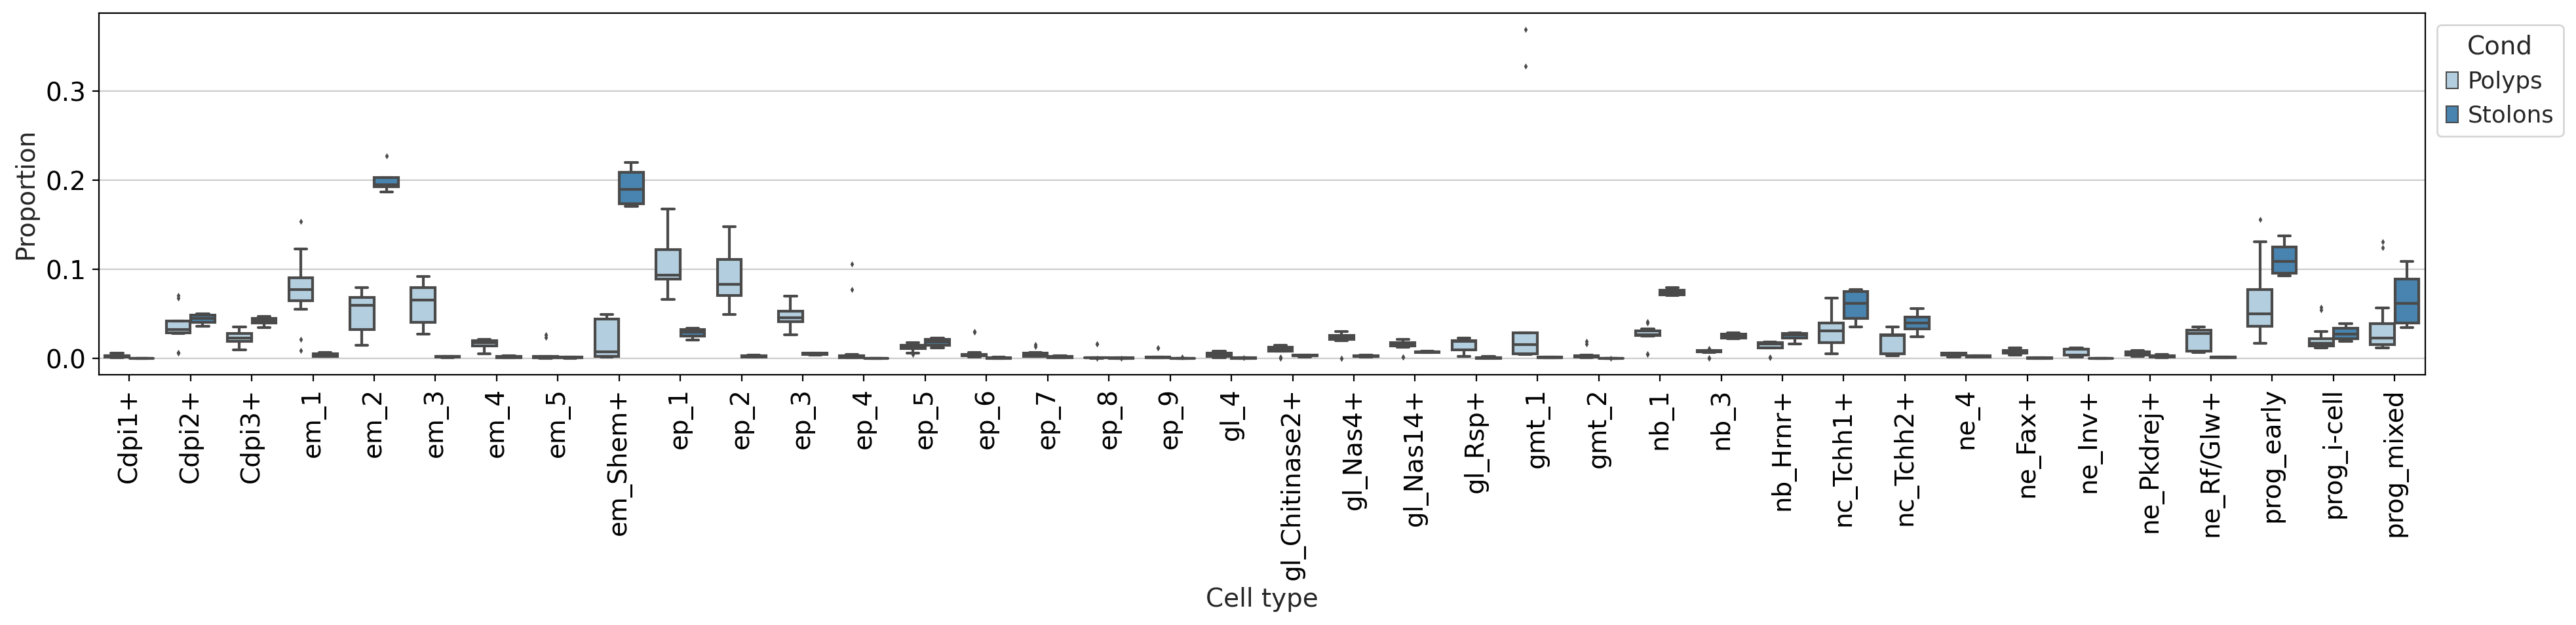

In [12]:
with plt.rc_context({'figure.figsize': (20, 5)}):
    viz.boxplots(comp_data_stol_pol, feature_name="Cond")#, add_dots=True,
                    #args_swarmplot={"palette": ["gray"]})
    plt.show()

In [52]:
# Run scCODA with each cell type as the reference
cell_types = comp_data_stol_pol.var.index
results_cycle = pd.DataFrame(index=cell_types, columns=["times_credible"]).fillna(0)

for ct in cell_types:
    print(f"Reference: {ct}")

    # Run inference
    model_temp = mod.CompositionalAnalysis(comp_data_stol_pol, formula="C(Cond, Treatment('Polyps'))", reference_cell_type=ct)
    temp_results = model_temp.sample_hmc(num_results=20000)

    # Select credible effects
    cred_eff = temp_results.credible_effects()
    cred_eff.index = cred_eff.index.droplevel(level=0)

    # add up credible effects
    results_cycle["times_credible"] += cred_eff.astype("int")

Reference: Cdpi1+
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:45<00:00, 88.54it/s]


MCMC sampling finished. (287.370 sec)
Acceptance rate: 34.1%
Reference: Cdpi2+
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:08<00:00, 80.38it/s]


MCMC sampling finished. (310.721 sec)
Acceptance rate: 50.8%
Reference: Cdpi3+
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:14<00:00, 78.45it/s]


MCMC sampling finished. (314.156 sec)
Acceptance rate: 58.7%
Reference: em_1
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:01<00:00, 82.70it/s]


MCMC sampling finished. (304.499 sec)
Acceptance rate: 32.8%
Reference: em_2
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:00<00:00, 83.22it/s]


MCMC sampling finished. (300.320 sec)
Acceptance rate: 52.8%
Reference: em_3
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:56<00:00, 84.47it/s]


MCMC sampling finished. (302.924 sec)
Acceptance rate: 50.1%
Reference: em_4
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:14<00:00, 78.65it/s]


MCMC sampling finished. (321.442 sec)
Acceptance rate: 65.8%
Reference: em_5
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:16<00:00, 78.00it/s]


MCMC sampling finished. (322.620 sec)
Acceptance rate: 57.8%
Reference: em_Shem+
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:20<00:00, 76.68it/s]


MCMC sampling finished. (328.839 sec)
Acceptance rate: 71.2%
Reference: ep_1
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:18<00:00, 77.30it/s]


MCMC sampling finished. (325.930 sec)
Acceptance rate: 62.0%
Reference: ep_2
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:15<00:00, 78.14it/s]


MCMC sampling finished. (321.767 sec)
Acceptance rate: 57.9%
Reference: ep_3
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:17<00:00, 77.75it/s]


MCMC sampling finished. (323.081 sec)
Acceptance rate: 43.6%
Reference: ep_4
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:16<00:00, 78.07it/s]


MCMC sampling finished. (318.398 sec)
Acceptance rate: 52.9%
Reference: ep_5
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:03<00:00, 82.01it/s]


MCMC sampling finished. (310.046 sec)
Acceptance rate: 49.0%
Reference: ep_6
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:58<00:00, 83.97it/s]


MCMC sampling finished. (306.641 sec)
Acceptance rate: 52.6%
Reference: ep_7
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:25<00:00, 75.42it/s]


MCMC sampling finished. (331.623 sec)
Acceptance rate: 64.2%
Reference: ep_8
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:24<00:00, 75.67it/s]


MCMC sampling finished. (331.820 sec)
Acceptance rate: 73.7%
Reference: ep_9
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:23<00:00, 75.96it/s]


MCMC sampling finished. (332.065 sec)
Acceptance rate: 36.7%
Reference: gl_4
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:27<00:00, 74.78it/s]


MCMC sampling finished. (334.843 sec)
Acceptance rate: 48.4%
Reference: gl_Chitinase2+
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:22<00:00, 76.26it/s]


MCMC sampling finished. (331.246 sec)
Acceptance rate: 40.0%
Reference: gl_Nas4+
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:25<00:00, 75.34it/s]


MCMC sampling finished. (333.297 sec)
Acceptance rate: 34.3%
Reference: gl_Nas14+
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:25<00:00, 75.31it/s]


MCMC sampling finished. (331.783 sec)
Acceptance rate: 60.6%
Reference: gl_Rsp+
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:23<00:00, 76.03it/s]


MCMC sampling finished. (330.670 sec)
Acceptance rate: 42.6%
Reference: gmt_1
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:16<00:00, 77.92it/s]


MCMC sampling finished. (319.840 sec)
Acceptance rate: 37.3%
Reference: gmt_2
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:23<00:00, 75.98it/s]


MCMC sampling finished. (329.476 sec)
Acceptance rate: 47.9%
Reference: nb_1
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:22<00:00, 76.21it/s]


MCMC sampling finished. (330.675 sec)
Acceptance rate: 60.6%
Reference: nb_3
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:23<00:00, 76.02it/s]


MCMC sampling finished. (331.254 sec)
Acceptance rate: 49.5%
Reference: nb_Hrnr+
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:37<00:00, 71.98it/s]


MCMC sampling finished. (349.258 sec)
Acceptance rate: 53.0%
Reference: nc_Tchh1+
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:20<00:00, 76.68it/s]


MCMC sampling finished. (327.921 sec)
Acceptance rate: 45.4%
Reference: nc_Tchh2+
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:28<00:00, 74.46it/s]


MCMC sampling finished. (337.986 sec)
Acceptance rate: 45.5%
Reference: ne_4
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:30<00:00, 73.97it/s]


MCMC sampling finished. (338.683 sec)
Acceptance rate: 36.0%
Reference: ne_Fax+
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:27<00:00, 74.66it/s]


MCMC sampling finished. (338.480 sec)
Acceptance rate: 42.7%
Reference: ne_Inv+
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:26<00:00, 75.07it/s]


MCMC sampling finished. (335.282 sec)
Acceptance rate: 64.0%
Reference: ne_Pkdrej+
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:24<00:00, 75.69it/s]


MCMC sampling finished. (331.258 sec)
Acceptance rate: 61.6%
Reference: ne_Rf/Glw+
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:23<00:00, 75.78it/s]


MCMC sampling finished. (332.408 sec)
Acceptance rate: 64.4%
Reference: prog_early
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:27<00:00, 74.75it/s]


MCMC sampling finished. (336.720 sec)
Acceptance rate: 52.0%
Reference: prog_i-cell
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:26<00:00, 74.95it/s]


MCMC sampling finished. (333.892 sec)
Acceptance rate: 54.2%
Reference: prog_mixed
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:24<00:00, 75.49it/s]


MCMC sampling finished. (332.464 sec)
Acceptance rate: 44.3%


In [53]:
# Calculate percentages
results_cycle["pct_credible"] = results_cycle["times_credible"]/len(cell_types)
results_cycle["is_credible"] = results_cycle["pct_credible"] > 0.5
print(results_cycle)

                  times_credible  pct_credible  is_credible
leiden_1.5_names                                           
Cdpi1+                         0      0.000000        False
Cdpi2+                        35      0.921053         True
Cdpi3+                        35      0.921053         True
em_1                          30      0.789474         True
em_2                          37      0.973684         True
em_3                          37      0.973684         True
em_4                           5      0.131579        False
em_5                           1      0.026316        False
em_Shem+                      37      0.973684         True
ep_1                          28      0.736842         True
ep_2                          37      0.973684         True
ep_3                          11      0.289474        False
ep_4                           0      0.000000        False
ep_5                          34      0.894737         True
ep_6                           1      0.

The compositional nature of scRNA-seq population data only allows statements about changes in abundance with respect to a reference group. One way of defining such a reference is by selecting one cell type and interpreting changes to the other cell types with respect to this reference type. scCODA achieves this by forcing all effects on the reference cell type to be zero. The reference should therefore be set to a cell type that is known to be unaffected by the covariates.

However, such a cell type might not be known a priori. To alleviate this problem, scCODA offers an automatic reference selection that aims at selecting a cell type that is mostly unchanged in relative abundance, implying that the abundance of the reference cell type is stable over all samples. This is achieved by selecting the cell type that has the least dispersion of relative abundance over all samples. 

For this tests, the reference cell type was selected after visually inspect the boxpots of relative abundance (turned out to be Cdpi1+ cells).

In [13]:
model_stol_pol = mod.CompositionalAnalysis(comp_data_stol_pol, formula="C(Cond, Treatment('Polyps'))", 
                                           reference_cell_type='Cdpi1+')

Zero counts encountered in data! Added a pseudocount of 0.5.


In [14]:
sim_results = model_stol_pol.sample_hmc()

  0%|                                                                                                     | 0/20000 [00:00<?, ?it/s]2023-10-27 09:32:30.772485: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f468c167e00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-10-27 09:32:30.772575: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-10-27 09:32:31.761341: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-27 09:32:33.775932: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|█████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:06<00:00, 81.05it/s]


MCMC sampling finished. (312.079 sec)
Acceptance rate: 56.1%


From the github of scCODA: 

scCODA performs parameter inference via Bayesian methods (HMC sampling). These methods, opposed to frequentist hypothesis testing, <u>**do not produce p-values**</u>. You can compare the confidence of effects via other measures, e.g. the inclusion probability, which is also used to get the credible effects at different FDR values.

The fold-changes in the summary are simply calculated by looking at the difference of expected compositions with/without the respective condition active, using the inferred parameters

In [15]:
sim_results.summary()

Compositional Analysis summary:

Data: 17 samples, 38 cell types
Reference index: 0
Formula: C(Cond, Treatment('Polyps'))

Intercepts:
                Final Parameter  Expected Sample
Cell Type                                       
Cdpi1+                   -0.640        75.361084
Cdpi2+                    1.039       403.949960
Cdpi3+                    0.798       317.440694
em_1                      1.689       773.782642
em_2                      1.435       600.216852
em_3                      1.628       727.992692
em_4                      0.480       230.970734
em_5                     -0.698        71.114483
em_Shem+                  0.186       172.137058
ep_1                      2.178      1261.795531
ep_2                      2.001      1057.106788
ep_3                      1.423       593.057293
ep_4                     -0.552        82.293408
ep_5                      0.333       199.395644
ep_6                     -0.262       109.979173
ep_7                     -0.192 

In [16]:
sim_results.summary_extended()

Compositional Analysis summary (extended):

Data: 17 samples, 38 cell types
Reference index: 0
Formula: C(Cond, Treatment('Polyps'))
Spike-and-slab threshold: 0.691

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 312.079 sec. Acceptance rate: 56.1%

Intercepts:
                Final Parameter  HDI 3%  HDI 97%     SD  Expected Sample
Cell Type                                                               
Cdpi1+                   -0.640  -1.076   -0.205  0.240        75.361084
Cdpi2+                    1.039   0.720    1.339  0.168       403.949960
Cdpi3+                    0.798   0.481    1.118  0.171       317.440694
em_1                      1.689   1.432    1.964  0.148       773.782642
em_2                      1.435   1.179    1.726  0.144       600.216852
em_3                      1.628   1.373    1.888  0.139       727.992692
em_4                      0.480   0.164    0.821  0.179       230.970734
em_5                     -0.698  -1.180   -0.280  0.241      

In [17]:
print(sim_results.credible_effects())

Covariate                                Cell Type     
C(Cond, Treatment('Polyps'))[T.Stolons]  Cdpi1+            False
                                         Cdpi2+             True
                                         Cdpi3+             True
                                         em_1               True
                                         em_2               True
                                         em_3               True
                                         em_4              False
                                         em_5              False
                                         em_Shem+           True
                                         ep_1               True
                                         ep_2               True
                                         ep_3              False
                                         ep_4              False
                                         ep_5               True
                                  

In [45]:
sim_results.set_fdr(est_fdr=0.005)
sim_results.summary()

Compositional Analysis summary:

Data: 17 samples, 38 cell types
Reference index: 0
Formula: C(Cond, Treatment('Polyps'))

Intercepts:
                Final Parameter  Expected Sample
Cell Type                                       
Cdpi1+                   -0.697        73.613636
Cdpi2+                    1.052       423.193823
Cdpi3+                    0.713       301.518171
em_1                      1.634       757.353625
em_2                      1.431       618.211285
em_3                      1.552       697.728658
em_4                      0.443       230.172789
em_5                     -0.711        72.590226
em_Shem+                  0.143       170.516196
ep_1                      2.180      1307.445202
ep_2                      1.973      1062.978641
ep_3                      1.376       585.127800
ep_4                     -0.564        84.085176
ep_5                      0.303       200.102610
ep_6                     -0.276       112.149218
ep_7                     -0.247 

In [46]:
print(sim_results.credible_effects())

Covariate                                Cell Type     
C(Cond, Treatment('Polyps'))[T.Stolons]  Cdpi1+            False
                                         Cdpi2+             True
                                         Cdpi3+             True
                                         em_1              False
                                         em_2               True
                                         em_3               True
                                         em_4              False
                                         em_5              False
                                         em_Shem+           True
                                         ep_1               True
                                         ep_2               True
                                         ep_3              False
                                         ep_4              False
                                         ep_5               True
                                  

In [50]:
sim_results.set_fdr(est_fdr=0.0005)
sim_results.summary()

Compositional Analysis summary:

Data: 17 samples, 38 cell types
Reference index: 0
Formula: C(Cond, Treatment('Polyps'))

Intercepts:
                Final Parameter  Expected Sample
Cell Type                                       
Cdpi1+                   -0.697        73.613636
Cdpi2+                    1.052       423.193823
Cdpi3+                    0.713       301.518171
em_1                      1.634       757.353625
em_2                      1.431       618.211285
em_3                      1.552       697.728658
em_4                      0.443       230.172789
em_5                     -0.711        72.590226
em_Shem+                  0.143       170.516196
ep_1                      2.180      1307.445202
ep_2                      1.973      1062.978641
ep_3                      1.376       585.127800
ep_4                     -0.564        84.085176
ep_5                      0.303       200.102610
ep_6                     -0.276       112.149218
ep_7                     -0.247 

In [51]:
print(sim_results.credible_effects())

Covariate                                Cell Type     
C(Cond, Treatment('Polyps'))[T.Stolons]  Cdpi1+            False
                                         Cdpi2+             True
                                         Cdpi3+             True
                                         em_1              False
                                         em_2               True
                                         em_3              False
                                         em_4              False
                                         em_5              False
                                         em_Shem+           True
                                         ep_1               True
                                         ep_2               True
                                         ep_3              False
                                         ep_4              False
                                         ep_5               True
                                  

### For only two specific conditions in the column 'Colony_part', must do a subset, results are not so clear when more than two conditions are used 

In [18]:
sexual_feed = adata.obs['Colony_part'].str.contains('Polyp_Sexual|Polyp_Feeding', regex=True, case= False)
s_f = adata[sexual_feed, :]
s_f.obs.pop('sample')
s_f.obs['Unique'].unique()

['lib_29_1_Polyps_Polyp_Sexual_PEG', 'lib_29_2_Polyps_Polyp_Sexual_PEG', 'lib_27_1_Polyps_Polyp_Feeding_PEG', 'lib_27_2_Polyps_Polyp_Feeding_PEG']
Categories (4, object): ['lib_27_1_Polyps_Polyp_Feeding_PEG', 'lib_27_2_Polyps_Polyp_Feeding_PEG', 'lib_29_1_Polyps_Polyp_Sexual_PEG', 'lib_29_2_Polyps_Polyp_Sexual_PEG']

In [19]:
s_f.obs

,Experiment,Library,Body_part,Presence_of_PEG,batch,n_counts,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden_1,leiden_1.5,leiden_2,Colony_part,Unique,leiden_1.5_names,broad_names
CTGTAGCCAAACATCGGACTAGTA-0-0,lib_29,lib_29_1,Polyps,PEG,3,52.0,50,50,52.0,0.0,0.0,0,0,13,Polyp_Sexual,lib_29_1_Polyps_Polyp_Sexual_PEG,ep_1,epithelial
CGAACTTACAAGACTAACAGATTC-0-0,lib_29,lib_29_1,Polyps,PEG,3,109.0,99,99,109.0,0.0,0.0,3,6,3,Polyp_Sexual,lib_29_1_Polyps_Polyp_Sexual_PEG,gmt_1,gametogenesis
AGAGTCAACGACACACGATAGACA-0-0,lib_29,lib_29_1,Polyps,PEG,3,124.0,107,107,124.0,0.0,0.0,2,4,4,Polyp_Sexual,lib_29_1_Polyps_Polyp_Sexual_PEG,prog_early,progenitors
CGCTGATCACGCTCGAAAGAGATC-0-0,lib_29,lib_29_1,Polyps,PEG,3,83.0,62,62,83.0,0.0,0.0,3,8,21,Polyp_Sexual,lib_29_1_Polyps_Polyp_Sexual_PEG,prog_mixed,progenitors
AAGACGGAGGAGAACACGAACTTA-0-0,lib_29,lib_29_1,Polyps,PEG,3,54.0,51,51,54.0,0.0,0.0,3,6,3,Polyp_Sexual,lib_29_1_Polyps_Polyp_Sexual_PEG,gmt_1,gametogenesis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GAGCTGAAATTGAGGACATACCAA-3-0,lib_27,lib_27_2,Polyps,PEG,2,259.0,179,179,259.0,0.0,0.0,5,3,12,Polyp_Feeding,lib_27_2_Polyps_Polyp_Feeding_PEG,em_2,epitheliomuscular
CGCTGATCCAATGGAAGTCGTAGA-3-0,lib_27,lib_27_2,Polyps,PEG,2,91.0,67,67,91.0,0.0,0.0,10,12,26,Polyp_Feeding,lib_27_2_Polyps_Polyp_Feeding_PEG,nb_1,nematoblast
GACTAGTAAACCGAGACATACCAA-3-0,lib_27,lib_27_2,Polyps,PEG,2,218.0,173,173,218.0,0.0,0.0,2,4,9,Polyp_Feeding,lib_27_2_Polyps_Polyp_Feeding_PEG,prog_early,progenitors
CATCAAGTGACTAGTAATAGCGAC-3-0,lib_27,lib_27_2,Polyps,PEG,2,105.0,79,79,105.0,0.0,0.0,14,17,20,Polyp_Feeding,lib_27_2_Polyps_Polyp_Feeding_PEG,gl_Nas4+,gland


In [21]:
feeding_experiment27_1_cells = (s_f.obs['Colony_part'].str.contains('Polyp_Feeding', regex=True, case= False)) & (s_f.obs['Library'].str.contains('lib_27_1'))
s_f.obs.loc[feeding_experiment27_1_cells,'sample']= '27_1_f'

feeding_experiment27_2_cells = (s_f.obs['Colony_part'].str.contains('Polyp_Feeding', regex=True, case= False)) & (s_f.obs['Library'].str.contains('lib_27_2'))
s_f.obs.loc[feeding_experiment27_2_cells,'sample']= '27_2_f'

sexual_experiment29_1_cells = (s_f.obs['Colony_part'].str.contains('Polyp_Sexual', regex=True, case= False)) & (s_f.obs['Library'].str.contains('lib_29_1'))
s_f.obs.loc[sexual_experiment29_1_cells,'sample']= '29_1_s'

sexual_experiment29_2_cells = (s_f.obs['Colony_part'].str.contains('Polyp_Sexual', regex=True, case= False)) & (s_f.obs['Library'].str.contains('lib_29_2'))
s_f.obs.loc[sexual_experiment29_2_cells,'sample']= '29_2_s'

In [22]:
s_f.obs['sample'].unique()

array(['29_1_s', '29_2_s', '27_1_f', '27_2_f'], dtype=object)

In [23]:
cov_df = pd.DataFrame({"Cond":["Polyp_Sexual", "Polyp_Feeding","Polyp_Sexual", "Polyp_Feeding"]}, 
                      index=["29_1_s","27_1_f","29_2_s","27_2_f"])
print(cov_df)

                 Cond
29_1_s   Polyp_Sexual
27_1_f  Polyp_Feeding
29_2_s   Polyp_Sexual
27_2_f  Polyp_Feeding


In [24]:
comp_data_sexual_feed = sccoda.util.cell_composition_data.from_scanpy(s_f, 
                                                                    cell_type_identifier='leiden_1.5_names', 
                                                                    sample_identifier='sample',
                                                                    covariate_df= cov_df)

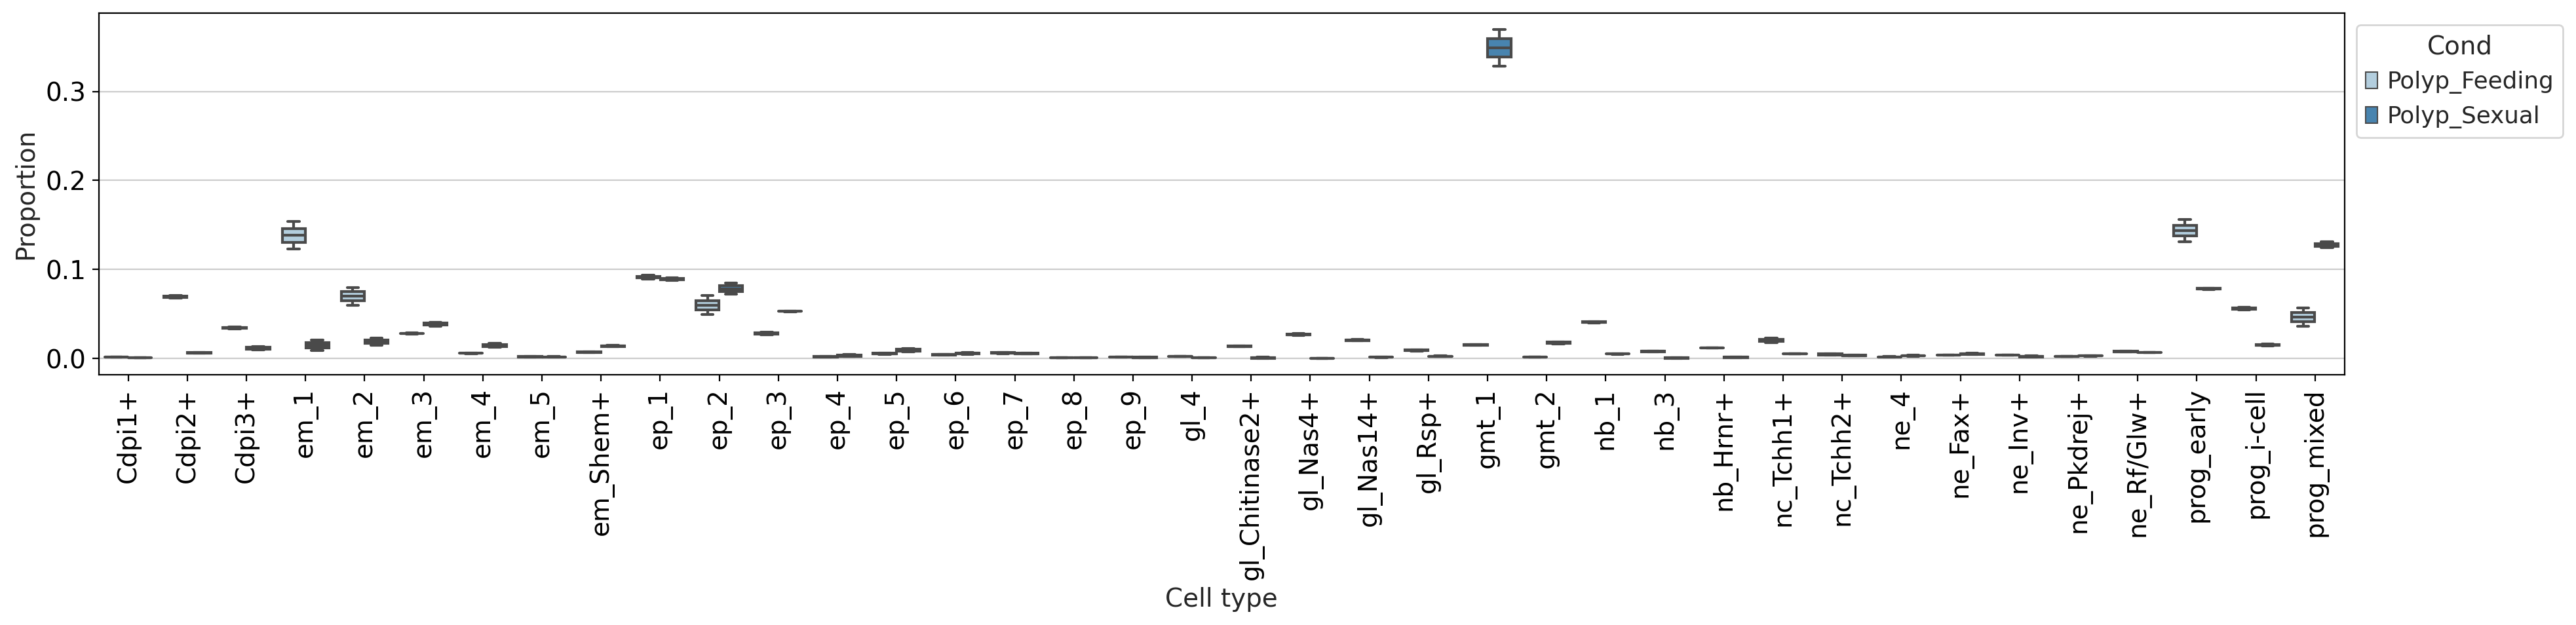

In [25]:
with plt.rc_context({'figure.figsize': (20, 5)}):
    viz.boxplots(comp_data_sexual_feed, feature_name="Cond")
    plt.show()

In [68]:
# Run scCODA with each cell type as the reference
cell_types = comp_data_sexual_feed.var.index
results_cycle = pd.DataFrame(index=cell_types, columns=["times_credible"]).fillna(0)

for ct in cell_types:
    print(f"Reference: {ct}")

    # Run inference
    model_temp = mod.CompositionalAnalysis(comp_data_sexual_feed, formula="C(Cond, Treatment('Polyp_Sexual'))", reference_cell_type=ct)
    temp_results = model_temp.sample_hmc(num_results=20000)

    # Select credible effects
    cred_eff = temp_results.credible_effects()
    cred_eff.index = cred_eff.index.droplevel(level=0)

    # add up credible effects
    results_cycle["times_credible"] += cred_eff.astype("int")

Reference: Cdpi1+


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:05<00:00, 107.54it/s]


MCMC sampling finished. (234.578 sec)
Acceptance rate: 74.7%
Reference: Cdpi2+


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:01<00:00, 110.46it/s]


MCMC sampling finished. (228.481 sec)
Acceptance rate: 43.6%
Reference: Cdpi3+


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:56<00:00, 113.08it/s]


MCMC sampling finished. (223.697 sec)
Acceptance rate: 39.3%
Reference: em_1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:56<00:00, 113.07it/s]


MCMC sampling finished. (223.620 sec)
Acceptance rate: 55.6%
Reference: em_2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:55<00:00, 113.92it/s]


MCMC sampling finished. (221.047 sec)
Acceptance rate: 35.5%
Reference: em_3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:54<00:00, 114.62it/s]


MCMC sampling finished. (220.287 sec)
Acceptance rate: 53.0%
Reference: em_4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:56<00:00, 113.12it/s]


MCMC sampling finished. (223.542 sec)
Acceptance rate: 45.7%
Reference: em_5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:57<00:00, 112.94it/s]


MCMC sampling finished. (223.990 sec)
Acceptance rate: 58.4%
Reference: em_Shem+


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:58<00:00, 112.12it/s]


MCMC sampling finished. (224.899 sec)
Acceptance rate: 62.0%
Reference: ep_1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:56<00:00, 113.63it/s]


MCMC sampling finished. (222.077 sec)
Acceptance rate: 47.5%
Reference: ep_2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:56<00:00, 113.25it/s]


MCMC sampling finished. (222.895 sec)
Acceptance rate: 36.0%
Reference: ep_3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:55<00:00, 113.68it/s]


MCMC sampling finished. (222.114 sec)
Acceptance rate: 29.2%
Reference: ep_4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:44<00:00, 121.92it/s]


MCMC sampling finished. (203.537 sec)
Acceptance rate: 49.2%
Reference: ep_5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:42<00:00, 123.09it/s]


MCMC sampling finished. (205.643 sec)
Acceptance rate: 48.9%
Reference: ep_6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:54<00:00, 114.66it/s]


MCMC sampling finished. (220.889 sec)
Acceptance rate: 63.4%
Reference: ep_7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:55<00:00, 113.81it/s]


MCMC sampling finished. (223.219 sec)
Acceptance rate: 47.5%
Reference: ep_8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:04<00:00, 108.25it/s]


MCMC sampling finished. (233.648 sec)
Acceptance rate: 56.7%
Reference: ep_9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:00<00:00, 110.95it/s]


MCMC sampling finished. (227.296 sec)
Acceptance rate: 54.8%
Reference: gl_4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:58<00:00, 111.86it/s]


MCMC sampling finished. (225.673 sec)
Acceptance rate: 42.5%
Reference: gl_Chitinase2+


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:53<00:00, 115.51it/s]


MCMC sampling finished. (218.921 sec)
Acceptance rate: 9.4%
Reference: gl_Nas4+


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:54<00:00, 114.30it/s]


MCMC sampling finished. (220.678 sec)
Acceptance rate: 49.1%
Reference: gl_Nas14+


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:41<00:00, 123.70it/s]


MCMC sampling finished. (202.332 sec)
Acceptance rate: 42.6%
Reference: gl_Rsp+


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:59<00:00, 111.35it/s]


MCMC sampling finished. (228.017 sec)
Acceptance rate: 65.1%
Reference: gmt_1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:01<00:00, 110.07it/s]


MCMC sampling finished. (229.217 sec)
Acceptance rate: 69.8%
Reference: gmt_2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:54<00:00, 114.85it/s]


MCMC sampling finished. (220.322 sec)
Acceptance rate: 47.7%
Reference: nb_1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:54<00:00, 114.53it/s]


MCMC sampling finished. (220.481 sec)
Acceptance rate: 53.6%
Reference: nb_3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:54<00:00, 114.90it/s]


MCMC sampling finished. (219.829 sec)
Acceptance rate: 59.9%
Reference: nb_Hrnr+


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:58<00:00, 112.12it/s]


MCMC sampling finished. (226.452 sec)
Acceptance rate: 45.5%
Reference: nc_Tchh1+


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:01<00:00, 110.41it/s]


MCMC sampling finished. (228.478 sec)
Acceptance rate: 51.4%
Reference: nc_Tchh2+


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:58<00:00, 111.86it/s]


MCMC sampling finished. (225.539 sec)
Acceptance rate: 41.8%
Reference: ne_4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:00<00:00, 110.55it/s]


MCMC sampling finished. (227.532 sec)
Acceptance rate: 40.6%
Reference: ne_Fax+


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:59<00:00, 111.24it/s]


MCMC sampling finished. (226.934 sec)
Acceptance rate: 59.8%
Reference: ne_Inv+


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:00<00:00, 110.72it/s]


MCMC sampling finished. (227.338 sec)
Acceptance rate: 41.3%
Reference: ne_Pkdrej+


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:02<00:00, 109.34it/s]


MCMC sampling finished. (230.585 sec)
Acceptance rate: 44.3%
Reference: ne_Rf/Glw+


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:47<00:00, 119.61it/s]


MCMC sampling finished. (210.345 sec)
Acceptance rate: 41.1%
Reference: prog_early


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:46<00:00, 119.93it/s]


MCMC sampling finished. (213.762 sec)
Acceptance rate: 42.1%
Reference: prog_i-cell


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:46<00:00, 119.98it/s]


MCMC sampling finished. (215.087 sec)
Acceptance rate: 57.6%
Reference: prog_mixed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:56<00:00, 113.25it/s]


MCMC sampling finished. (222.345 sec)
Acceptance rate: 60.3%


In [69]:
# Calculate percentages
results_cycle["pct_credible"] = results_cycle["times_credible"]/len(cell_types)
results_cycle["is_credible"] = results_cycle["pct_credible"] > 0.5
print(results_cycle)

                  times_credible  pct_credible  is_credible
leiden_1.5_names                                           
Cdpi1+                         2      0.052632        False
Cdpi2+                        37      0.973684         True
Cdpi3+                        30      0.789474         True
em_1                          37      0.973684         True
em_2                          32      0.842105         True
em_3                          13      0.342105        False
em_4                          34      0.894737         True
em_5                           2      0.052632        False
em_Shem+                      27      0.710526         True
ep_1                          22      0.578947         True
ep_2                          18      0.473684        False
ep_3                          35      0.921053         True
ep_4                          10      0.263158        False
ep_5                          13      0.342105        False
ep_6                           9      0.

In [26]:
model_sexual_feed = mod.CompositionalAnalysis(comp_data_sexual_feed, formula="C(Cond, Treatment('Polyp_Feeding'))", reference_cell_type='Cdpi1+')

In [27]:
sim_results = model_sexual_feed.sample_hmc()

100%|████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:48<00:00, 118.90it/s]


MCMC sampling finished. (212.882 sec)
Acceptance rate: 19.9%


In [28]:
sim_results.summary()

Compositional Analysis summary:

Data: 4 samples, 38 cell types
Reference index: 0
Formula: C(Cond, Treatment('Polyp_Feeding'))

Intercepts:
                Final Parameter  Expected Sample
Cell Type                                       
Cdpi1+                    1.212        19.973284
Cdpi2+                    4.985       869.045589
Cdpi3+                    4.364       467.030976
em_1                      5.664      1713.675205
em_2                      5.061       937.667666
em_3                      3.970       314.944233
em_4                      2.388        64.741058
em_5                      1.368        23.345298
em_Shem+                  2.835       101.230044
ep_1                      5.266      1151.010563
ep_2                      4.794       717.946882
ep_3                      4.092       355.809539
ep_4                      1.061        17.173982
ep_5                      2.456        69.296582
ep_6                      2.104        48.734909
ep_7                      

In [29]:
sim_results.summary_extended()

Compositional Analysis summary (extended):

Data: 4 samples, 38 cell types
Reference index: 0
Formula: C(Cond, Treatment('Polyp_Feeding'))
Spike-and-slab threshold: 0.828

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 212.882 sec. Acceptance rate: 19.9%

Intercepts:
                Final Parameter  HDI 3%  HDI 97%     SD  Expected Sample
Cell Type                                                               
Cdpi1+                    1.212   0.681    1.471  0.244        19.973284
Cdpi2+                    4.985   4.722    5.189  0.118       869.045589
Cdpi3+                    4.364   4.013    4.523  0.153       467.030976
em_1                      5.664   5.391    5.843  0.116      1713.675205
em_2                      5.061   4.697    5.188  0.160       937.667666
em_3                      3.970   3.800    4.224  0.103       314.944233
em_4                      2.388   2.126    2.683  0.142        64.741058
em_5                      1.368   0.952    1.657  0.175

In [31]:
print(sim_results.credible_effects())

Covariate                                            Cell Type     
C(Cond, Treatment('Polyp_Feeding'))[T.Polyp_Sexual]  Cdpi1+            False
                                                     Cdpi2+             True
                                                     Cdpi3+             True
                                                     em_1               True
                                                     em_2               True
                                                     em_3               True
                                                     em_4               True
                                                     em_5              False
                                                     em_Shem+           True
                                                     ep_1              False
                                                     ep_2               True
                                                     ep_3               True
        

In [ ]:
sim_results.set_fdr(est_fdr=0.005)
sim_results.summary()

In [33]:
print(sim_results.credible_effects())

Covariate                                            Cell Type     
C(Cond, Treatment('Polyp_Feeding'))[T.Polyp_Sexual]  Cdpi1+            False
                                                     Cdpi2+             True
                                                     Cdpi3+             True
                                                     em_1               True
                                                     em_2               True
                                                     em_3              False
                                                     em_4               True
                                                     em_5              False
                                                     em_Shem+           True
                                                     ep_1              False
                                                     ep_2              False
                                                     ep_3               True
        

In [34]:
sim_results.set_fdr(est_fdr=0.0005)
sim_results.summary()

Compositional Analysis summary:

Data: 4 samples, 38 cell types
Reference index: 0
Formula: C(Cond, Treatment('Polyp_Feeding'))

Intercepts:
                Final Parameter  Expected Sample
Cell Type                                       
Cdpi1+                    1.212        19.973284
Cdpi2+                    4.985       869.045589
Cdpi3+                    4.364       467.030976
em_1                      5.664      1713.675205
em_2                      5.061       937.667666
em_3                      3.970       314.944233
em_4                      2.388        64.741058
em_5                      1.368        23.345298
em_Shem+                  2.835       101.230044
ep_1                      5.266      1151.010563
ep_2                      4.794       717.946882
ep_3                      4.092       355.809539
ep_4                      1.061        17.173982
ep_5                      2.456        69.296582
ep_6                      2.104        48.734909
ep_7                      

In [35]:
print(sim_results.credible_effects())

Covariate                                            Cell Type     
C(Cond, Treatment('Polyp_Feeding'))[T.Polyp_Sexual]  Cdpi1+            False
                                                     Cdpi2+             True
                                                     Cdpi3+             True
                                                     em_1               True
                                                     em_2               True
                                                     em_3              False
                                                     em_4               True
                                                     em_5              False
                                                     em_Shem+          False
                                                     ep_1              False
                                                     ep_2              False
                                                     ep_3               True
        

### Stolon vs. Feeding Polyps

In [59]:
stolon_feed = adata.obs['Colony_part'].str.contains('Polyp_Feeding|Stolon', regex=True, case= False)
stol_f = adata[stolon_feed, :]
stol_f.obs.pop('sample')
stol_f.obs['Unique'].unique()

['lib_27_1_Polyps_Polyp_Feeding_PEG', 'lib_27_2_Polyps_Polyp_Feeding_PEG', 'lib_20_1_Stolons_Stolon_noPEG', 'lib_20_2_Stolons_Stolon_noPEG', 'lib_20_3_Stolons_Stolon_PEG', 'lib_20_4_Stolons_Stolon_PEG']
Categories (6, object): ['lib_20_1_Stolons_Stolon_noPEG', 'lib_20_2_Stolons_Stolon_noPEG', 'lib_20_3_Stolons_Stolon_PEG', 'lib_20_4_Stolons_Stolon_PEG', 'lib_27_1_Polyps_Polyp_Feeding_PEG', 'lib_27_2_Polyps_Polyp_Feeding_PEG']

In [60]:
stol_f.obs

,Experiment,Library,Body_part,Presence_of_PEG,batch,n_counts,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden_1,leiden_1.5,leiden_2,Colony_part,Unique,leiden_1.5_names,broad_names
AGTACAAGCCTCTATCTGGCTTCA-2-0,lib_27,lib_27_1,Polyps,PEG,2,187.0,142,142,187.0,0.0,0.0,17,22,25,Polyp_Feeding,lib_27_1_Polyps_Polyp_Feeding_PEG,gl_Nas14+,gland
CCAGTTCACTGTAGCCATAGCGAC-2-0,lib_27,lib_27_1,Polyps,PEG,2,448.0,305,305,448.0,0.0,0.0,4,2,2,Polyp_Feeding,lib_27_1_Polyps_Polyp_Feeding_PEG,em_1,epitheliomuscular
ACCACTGTAACGCTTACAAGGAGC-2-0,lib_27,lib_27_1,Polyps,PEG,2,626.0,400,400,626.0,0.0,0.0,2,14,4,Polyp_Feeding,lib_27_1_Polyps_Polyp_Feeding_PEG,prog_i-cell,progenitors
CTCAATGAGTCTGTCACAGATCTG-2-0,lib_27,lib_27_1,Polyps,PEG,2,138.0,97,97,138.0,0.0,0.0,2,4,15,Polyp_Feeding,lib_27_1_Polyps_Polyp_Feeding_PEG,prog_early,progenitors
CTGTAGCCCAAGGAGCAAGAGATC-2-0,lib_27,lib_27_1,Polyps,PEG,2,126.0,87,87,126.0,0.0,0.0,3,6,3,Polyp_Feeding,lib_27_1_Polyps_Polyp_Feeding_PEG,gmt_1,gametogenesis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACCTCCAACTGTAGCCACAGCAGA-3-1,lib_20,lib_20_4,Stolons,PEG,1,101.0,69,69,101.0,0.0,0.0,21,25,26,Stolon,lib_20_4_Stolons_Stolon_PEG,nb_3,nematoblast
CTGTAGCCTCTTCACAACACAGAA-3-1,lib_20,lib_20_4,Stolons,PEG,1,86.0,76,76,86.0,0.0,0.0,5,3,12,Stolon,lib_20_4_Stolons_Stolon_PEG,em_2,epitheliomuscular
ACCACTGTAGTGGTCAGCGAGTAA-3-1,lib_20,lib_20_4,Stolons,PEG,1,130.0,113,113,130.0,0.0,0.0,6,15,19,Stolon,lib_20_4_Stolons_Stolon_PEG,nc_Tchh2+,nematocyte
CAGATCTGATGCCTAAAATGTTGC-3-1,lib_20,lib_20_4,Stolons,PEG,1,232.0,186,186,232.0,0.0,0.0,11,13,17,Stolon,lib_20_4_Stolons_Stolon_PEG,Cdpi3+,Cdpi+ cells


In [62]:
feeding_experiment27_1_cells = (stol_f.obs['Colony_part'].str.contains('Polyp_Feeding', regex=True, case= False)) & (stol_f.obs['Library'].str.contains('lib_27_1'))
feeding_experiment27_2_cells = (stol_f.obs['Colony_part'].str.contains('Polyp_Feeding', regex=True, case= False)) & (stol_f.obs['Library'].str.contains('lib_27_2'))

stolon_library20_1_cells = (stol_f.obs['Body_part'].str.contains('Stolons', regex=True, case= False)) & (stol_f.obs['Library'].str.contains('lib_20_1'))
stolon_library20_2_cells = (stol_f.obs['Body_part'].str.contains('Stolons', regex=True, case= False)) & (stol_f.obs['Library'].str.contains('lib_20_2'))
stolon_library20_3_cells = (stol_f.obs['Body_part'].str.contains('Stolons', regex=True, case= False)) & (stol_f.obs['Library'].str.contains('lib_20_3'))
stolon_library20_4_cells = (stol_f.obs['Body_part'].str.contains('Stolons', regex=True, case= False)) & (stol_f.obs['Library'].str.contains('lib_20_4'))

stol_f.obs.loc[feeding_experiment27_1_cells,'sample']= '27_1_f'
stol_f.obs.loc[feeding_experiment27_2_cells,'sample']= '27_2_f'
stol_f.obs.loc[stolon_library20_1_cells,'sample']= '20_1_s'
stol_f.obs.loc[stolon_library20_2_cells,'sample']= '20_2_s'
stol_f.obs.loc[stolon_library20_3_cells,'sample']= '20_3_s'
stol_f.obs.loc[stolon_library20_4_cells,'sample']= '20_4_s'

In [64]:
stol_f.obs['sample'].unique()

array(['27_1_f', '27_2_f', '20_1_s', '20_2_s', '20_3_s', '20_4_s'],
      dtype=object)

In [66]:
cov_df = pd.DataFrame({"Cond":["Polyp_Feeding","Polyp_Feeding","Stolons","Stolons","Stolons","Stolons"]}, 
                      index=["27_1_f","27_2_f","20_1_s","20_2_s","20_3_s","20_4_s"])
print(cov_df)

                 Cond
27_1_f  Polyp_Feeding
27_2_f  Polyp_Feeding
20_1_s        Stolons
20_2_s        Stolons
20_3_s        Stolons
20_4_s        Stolons


In [67]:
comp_data_stolon_feed = sccoda.util.cell_composition_data.from_scanpy(stol_f, 
                                                                    cell_type_identifier='leiden_1.5_names', 
                                                                    sample_identifier='sample',
                                                                    covariate_df= cov_df)

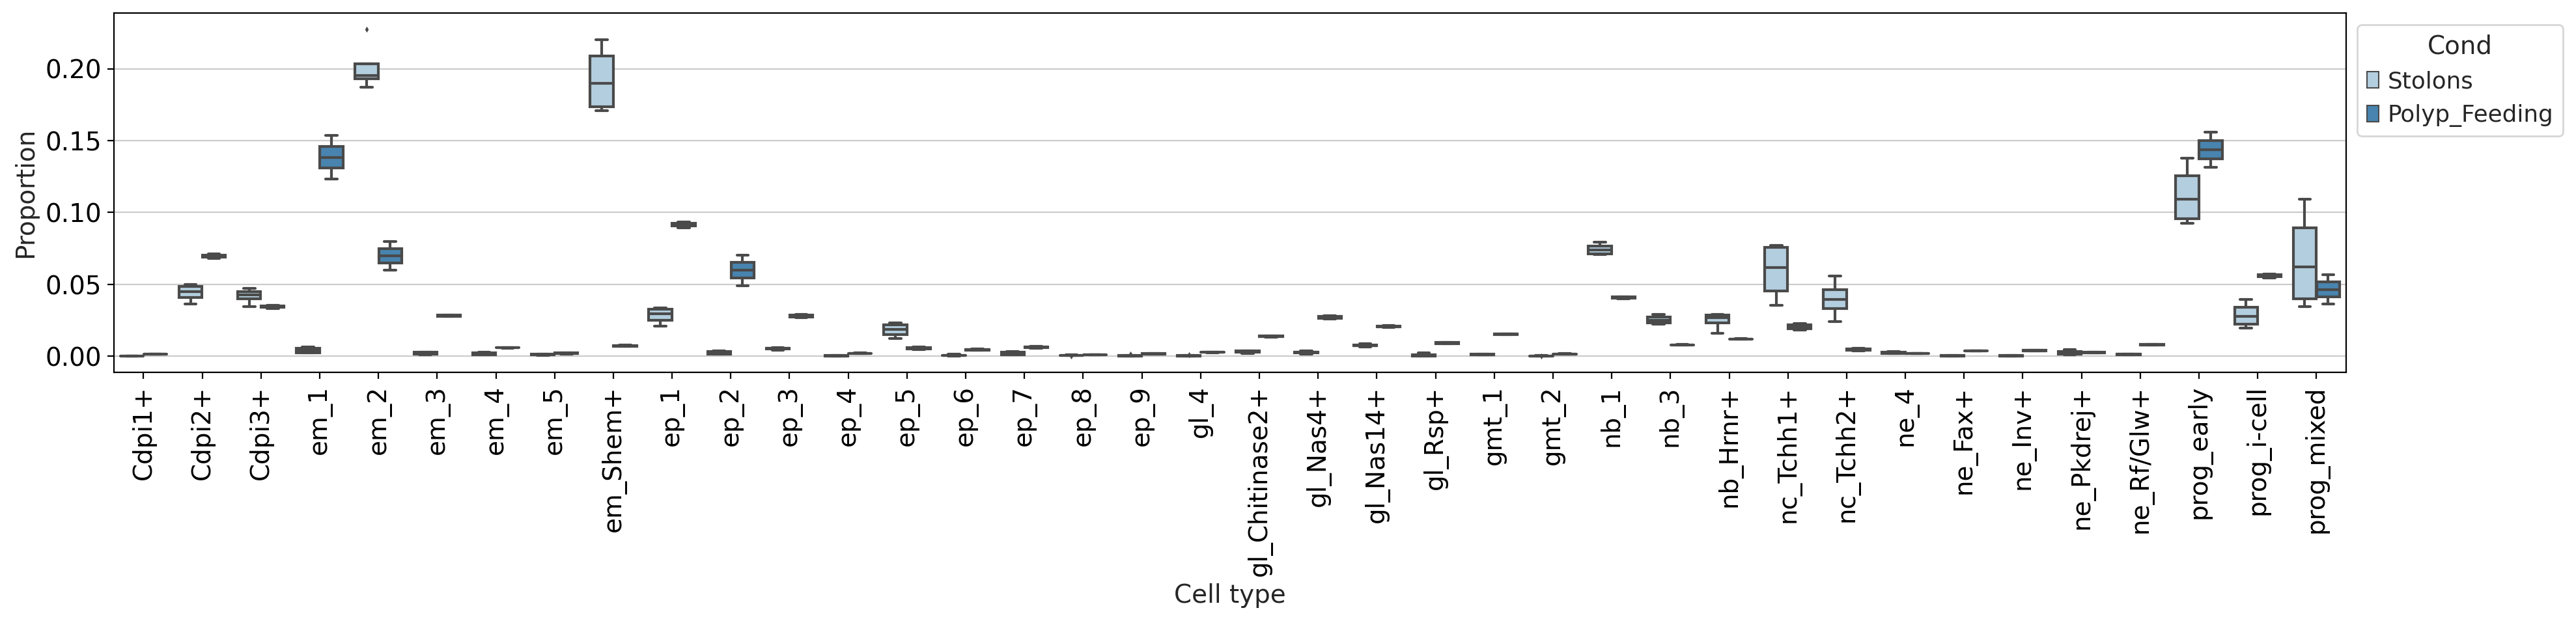

In [68]:
with plt.rc_context({'figure.figsize': (20, 5)}):
    viz.boxplots(comp_data_stolon_feed, feature_name="Cond")
    plt.show()

In [69]:
model_stolon_feed = mod.CompositionalAnalysis(comp_data_stolon_feed, formula="C(Cond, Treatment('Polyp_Feeding'))", reference_cell_type='Cdpi1+')

Zero counts encountered in data! Added a pseudocount of 0.5.


In [70]:
sim_results = model_stolon_feed.sample_hmc()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:52<00:00, 115.62it/s]


MCMC sampling finished. (220.272 sec)
Acceptance rate: 51.6%


In [71]:
sim_results.summary()

Compositional Analysis summary:

Data: 6 samples, 38 cell types
Reference index: 0
Formula: C(Cond, Treatment('Polyp_Feeding'))

Intercepts:
                Final Parameter  Expected Sample
Cell Type                                       
Cdpi1+                   -0.446         8.681577
Cdpi2+                    3.687       541.424257
Cdpi3+                    2.974       265.390727
em_1                      4.342      1042.318857
em_2                      3.655       524.372956
em_3                      2.738       209.600467
em_4                      0.994        36.642295
em_5                      0.270        17.764519
em_Shem+                  1.535        62.941340
ep_1                      3.916       680.755479
ep_2                      3.483       441.511108
ep_3                      2.727       207.307496
ep_4                      0.022        13.862719
ep_5                      1.247        47.190999
ep_6                      0.789        29.850547
ep_7                      

In [72]:
sim_results.summary_extended()

Compositional Analysis summary (extended):

Data: 6 samples, 38 cell types
Reference index: 0
Formula: C(Cond, Treatment('Polyp_Feeding'))
Spike-and-slab threshold: 0.721

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 220.272 sec. Acceptance rate: 51.6%

Intercepts:
                Final Parameter  HDI 3%  HDI 97%     SD  Expected Sample
Cell Type                                                               
Cdpi1+                   -0.446  -1.292    0.257  0.417         8.681577
Cdpi2+                    3.687   3.341    4.013  0.180       541.424257
Cdpi3+                    2.974   2.445    3.416  0.259       265.390727
em_1                      4.342   3.966    4.759  0.213      1042.318857
em_2                      3.655   3.236    4.068  0.228       524.372956
em_3                      2.738   2.215    3.206  0.267       209.600467
em_4                      0.994   0.230    1.697  0.389        36.642295
em_5                      0.270  -0.541    1.052  0.444

In [73]:
print(sim_results.credible_effects())

Covariate                                       Cell Type     
C(Cond, Treatment('Polyp_Feeding'))[T.Stolons]  Cdpi1+            False
                                                Cdpi2+            False
                                                Cdpi3+             True
                                                em_1               True
                                                em_2               True
                                                em_3               True
                                                em_4              False
                                                em_5              False
                                                em_Shem+           True
                                                ep_1               True
                                                ep_2               True
                                                ep_3               True
                                                ep_4              False
 

### Stolon vs. Sexual Polyps

In [76]:
stolon_sexual = adata.obs['Colony_part'].str.contains('Polyp_Sexual|Stolon', regex=True, case= False)
stol_s = adata[stolon_sexual, :]
stol_s.obs.pop('sample')
stol_s.obs['Unique'].unique()

['lib_29_1_Polyps_Polyp_Sexual_PEG', 'lib_29_2_Polyps_Polyp_Sexual_PEG', 'lib_20_1_Stolons_Stolon_noPEG', 'lib_20_2_Stolons_Stolon_noPEG', 'lib_20_3_Stolons_Stolon_PEG', 'lib_20_4_Stolons_Stolon_PEG']
Categories (6, object): ['lib_20_1_Stolons_Stolon_noPEG', 'lib_20_2_Stolons_Stolon_noPEG', 'lib_20_3_Stolons_Stolon_PEG', 'lib_20_4_Stolons_Stolon_PEG', 'lib_29_1_Polyps_Polyp_Sexual_PEG', 'lib_29_2_Polyps_Polyp_Sexual_PEG']

In [77]:
stol_s.obs

,Experiment,Library,Body_part,Presence_of_PEG,batch,n_counts,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden_1,leiden_1.5,leiden_2,Colony_part,Unique,leiden_1.5_names,broad_names
CTGTAGCCAAACATCGGACTAGTA-0-0,lib_29,lib_29_1,Polyps,PEG,3,52.0,50,50,52.0,0.0,0.0,0,0,13,Polyp_Sexual,lib_29_1_Polyps_Polyp_Sexual_PEG,ep_1,epithelial
CGAACTTACAAGACTAACAGATTC-0-0,lib_29,lib_29_1,Polyps,PEG,3,109.0,99,99,109.0,0.0,0.0,3,6,3,Polyp_Sexual,lib_29_1_Polyps_Polyp_Sexual_PEG,gmt_1,gametogenesis
AGAGTCAACGACACACGATAGACA-0-0,lib_29,lib_29_1,Polyps,PEG,3,124.0,107,107,124.0,0.0,0.0,2,4,4,Polyp_Sexual,lib_29_1_Polyps_Polyp_Sexual_PEG,prog_early,progenitors
CGCTGATCACGCTCGAAAGAGATC-0-0,lib_29,lib_29_1,Polyps,PEG,3,83.0,62,62,83.0,0.0,0.0,3,8,21,Polyp_Sexual,lib_29_1_Polyps_Polyp_Sexual_PEG,prog_mixed,progenitors
AAGACGGAGGAGAACACGAACTTA-0-0,lib_29,lib_29_1,Polyps,PEG,3,54.0,51,51,54.0,0.0,0.0,3,6,3,Polyp_Sexual,lib_29_1_Polyps_Polyp_Sexual_PEG,gmt_1,gametogenesis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACCTCCAACTGTAGCCACAGCAGA-3-1,lib_20,lib_20_4,Stolons,PEG,1,101.0,69,69,101.0,0.0,0.0,21,25,26,Stolon,lib_20_4_Stolons_Stolon_PEG,nb_3,nematoblast
CTGTAGCCTCTTCACAACACAGAA-3-1,lib_20,lib_20_4,Stolons,PEG,1,86.0,76,76,86.0,0.0,0.0,5,3,12,Stolon,lib_20_4_Stolons_Stolon_PEG,em_2,epitheliomuscular
ACCACTGTAGTGGTCAGCGAGTAA-3-1,lib_20,lib_20_4,Stolons,PEG,1,130.0,113,113,130.0,0.0,0.0,6,15,19,Stolon,lib_20_4_Stolons_Stolon_PEG,nc_Tchh2+,nematocyte
CAGATCTGATGCCTAAAATGTTGC-3-1,lib_20,lib_20_4,Stolons,PEG,1,232.0,186,186,232.0,0.0,0.0,11,13,17,Stolon,lib_20_4_Stolons_Stolon_PEG,Cdpi3+,Cdpi+ cells


In [79]:
sexual_experiment29_1_cells = (stol_s.obs['Colony_part'].str.contains('Polyp_Sexual', regex=True, case= False)) & (stol_s.obs['Library'].str.contains('lib_29_1'))
sexual_experiment29_2_cells = (stol_s.obs['Colony_part'].str.contains('Polyp_Sexual', regex=True, case= False)) & (stol_s.obs['Library'].str.contains('lib_29_2'))

stolon_library20_1_cells = (stol_s.obs['Body_part'].str.contains('Stolons', regex=True, case= False)) & (stol_s.obs['Library'].str.contains('lib_20_1'))
stolon_library20_2_cells = (stol_s.obs['Body_part'].str.contains('Stolons', regex=True, case= False)) & (stol_s.obs['Library'].str.contains('lib_20_2'))
stolon_library20_3_cells = (stol_s.obs['Body_part'].str.contains('Stolons', regex=True, case= False)) & (stol_s.obs['Library'].str.contains('lib_20_3'))
stolon_library20_4_cells = (stol_s.obs['Body_part'].str.contains('Stolons', regex=True, case= False)) & (stol_s.obs['Library'].str.contains('lib_20_4'))

stol_s.obs.loc[sexual_experiment29_2_cells,'sample']= '29_2_s'
stol_s.obs.loc[sexual_experiment29_1_cells,'sample']= '29_1_s'
stol_s.obs.loc[stolon_library20_1_cells,'sample']= '20_1_s'
stol_s.obs.loc[stolon_library20_2_cells,'sample']= '20_2_s'
stol_s.obs.loc[stolon_library20_3_cells,'sample']= '20_3_s'
stol_s.obs.loc[stolon_library20_4_cells,'sample']= '20_4_s'

In [80]:
stol_s.obs['sample'].unique()

array(['29_1_s', '29_2_s', '20_1_s', '20_2_s', '20_3_s', '20_4_s'],
      dtype=object)

In [81]:
cov_df = pd.DataFrame({"Cond":["Polyp_Sexual","Polyp_Sexual","Stolons","Stolons","Stolons","Stolons"]}, 
                      index=["29_1_s","29_2_s","20_1_s","20_2_s","20_3_s","20_4_s"])
print(cov_df)

                Cond
29_1_s  Polyp_Sexual
29_2_s  Polyp_Sexual
20_1_s       Stolons
20_2_s       Stolons
20_3_s       Stolons
20_4_s       Stolons


In [82]:
comp_data_stolon_sexual = sccoda.util.cell_composition_data.from_scanpy(stol_s, 
                                                                    cell_type_identifier='leiden_1.5_names', 
                                                                    sample_identifier='sample',
                                                                    covariate_df= cov_df)

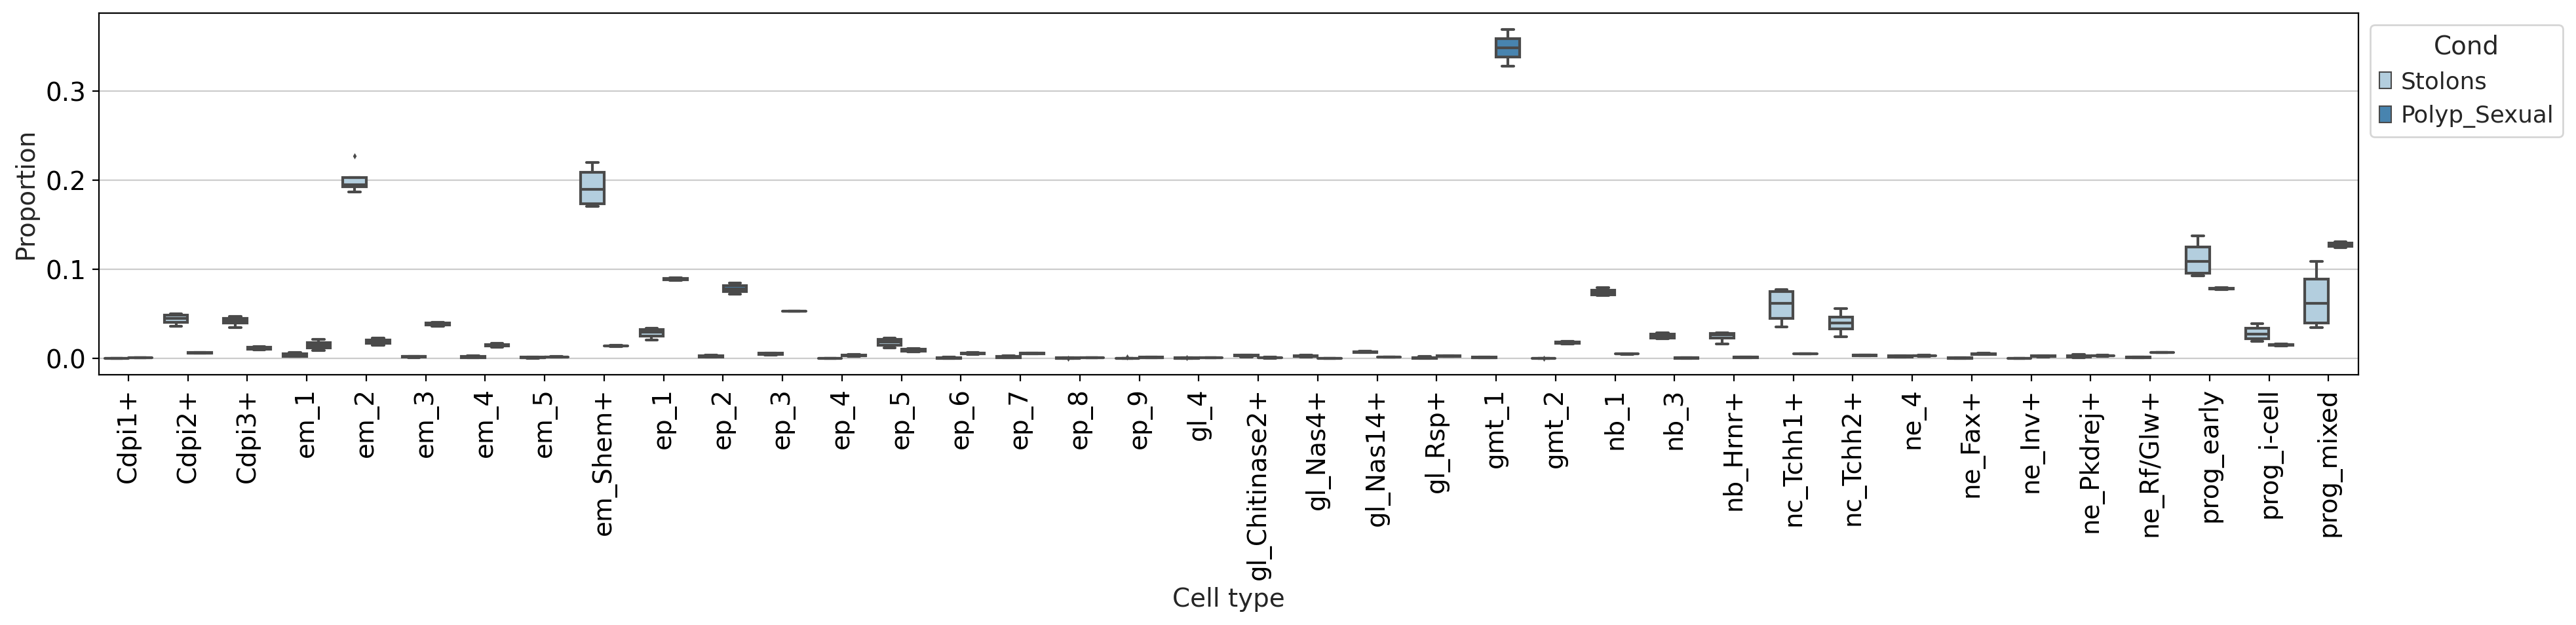

In [83]:
with plt.rc_context({'figure.figsize': (20, 5)}):
    viz.boxplots(comp_data_stolon_sexual, feature_name="Cond")
    plt.show()

In [84]:
model_stolon_sexual = mod.CompositionalAnalysis(comp_data_stolon_sexual, formula="C(Cond, Treatment('Polyp_Sexual'))", reference_cell_type='Cdpi1+')

Zero counts encountered in data! Added a pseudocount of 0.5.


In [85]:
sim_results = model_stolon_sexual.sample_hmc()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:55<00:00, 113.79it/s]


MCMC sampling finished. (224.390 sec)
Acceptance rate: 33.0%


In [86]:
sim_results.summary()

Compositional Analysis summary:

Data: 6 samples, 38 cell types
Reference index: 0
Formula: C(Cond, Treatment('Polyp_Sexual'))

Intercepts:
                Final Parameter  Expected Sample
Cell Type                                       
Cdpi1+                   -0.325         3.304587
Cdpi2+                    2.131        38.525153
Cdpi3+                    2.756        71.974462
em_1                      2.916        84.462814
em_2                      3.249       117.838066
em_3                      3.989       246.980988
em_4                      3.005        92.324668
em_5                      0.749         9.672737
em_Shem+                  2.992        91.132215
ep_1                      4.818       565.840005
ep_2                      4.692       498.852949
ep_3                      4.263       324.833051
ep_4                      1.092        13.630520
ep_5                      2.577        60.178272
ep_6                      1.964        32.599970
ep_7                      1

In [87]:
sim_results.summary_extended()

Compositional Analysis summary (extended):

Data: 6 samples, 38 cell types
Reference index: 0
Formula: C(Cond, Treatment('Polyp_Sexual'))
Spike-and-slab threshold: 0.668

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 224.390 sec. Acceptance rate: 33.0%

Intercepts:
                Final Parameter  HDI 3%  HDI 97%     SD  Expected Sample
Cell Type                                                               
Cdpi1+                   -0.325  -1.260    0.130  0.408         3.304587
Cdpi2+                    2.131   1.530    2.522  0.307        38.525153
Cdpi3+                    2.756   2.081    3.082  0.324        71.974462
em_1                      2.916   2.445    3.284  0.258        84.462814
em_2                      3.249   2.607    3.542  0.296       117.838066
em_3                      3.989   3.566    4.361  0.299       246.980988
em_4                      3.005   2.534    3.370  0.289        92.324668
em_5                      0.749  -0.197    1.337  0.536 

In [88]:
print(sim_results.credible_effects())

Covariate                                      Cell Type     
C(Cond, Treatment('Polyp_Sexual'))[T.Stolons]  Cdpi1+            False
                                               Cdpi2+             True
                                               Cdpi3+             True
                                               em_1               True
                                               em_2               True
                                               em_3               True
                                               em_4               True
                                               em_5              False
                                               em_Shem+           True
                                               ep_1               True
                                               ep_2               True
                                               ep_3               True
                                               ep_4               True
               

In [7]:
adata.obs

,Experiment,Library,Body_part,Presence_of_PEG,batch,n_counts,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden_1,leiden_1.5,leiden_2,Colony_part,Unique,leiden_1.5_names,broad_names
CTGTAGCCAAACATCGGACTAGTA-0-0,lib_29,lib_29_1,Polyps,PEG,3,52.0,50,50,52.0,0.0,0.0,0,0,13,Polyp_Sexual,lib_29_1_Polyps_Polyp_Sexual_PEG,ep_1,epithelial
CGAACTTACAAGACTAACAGATTC-0-0,lib_29,lib_29_1,Polyps,PEG,3,109.0,99,99,109.0,0.0,0.0,3,6,3,Polyp_Sexual,lib_29_1_Polyps_Polyp_Sexual_PEG,gmt_1,gametogenesis
AGAGTCAACGACACACGATAGACA-0-0,lib_29,lib_29_1,Polyps,PEG,3,124.0,107,107,124.0,0.0,0.0,2,4,4,Polyp_Sexual,lib_29_1_Polyps_Polyp_Sexual_PEG,prog_early,progenitors
CGCTGATCACGCTCGAAAGAGATC-0-0,lib_29,lib_29_1,Polyps,PEG,3,83.0,62,62,83.0,0.0,0.0,3,8,21,Polyp_Sexual,lib_29_1_Polyps_Polyp_Sexual_PEG,prog_mixed,progenitors
AAGACGGAGGAGAACACGAACTTA-0-0,lib_29,lib_29_1,Polyps,PEG,3,54.0,51,51,54.0,0.0,0.0,3,6,3,Polyp_Sexual,lib_29_1_Polyps_Polyp_Sexual_PEG,gmt_1,gametogenesis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAATGGAAGAATCTGAATAGCGAC-3-1,lib_20,lib_20_4,Polyps,PEG,1,74.0,70,70,74.0,0.0,0.0,0,0,0,Polyp_Mix,lib_20_4_Polyps_Polyp_Mix_PEG,ep_1,epithelial
AAGGTACACACCTTACCAGCGTTA-3-1,lib_20,lib_20_4,Polyps,PEG,1,58.0,52,52,58.0,0.0,0.0,6,15,19,Polyp_Mix,lib_20_4_Polyps_Polyp_Mix_PEG,nc_Tchh2+,nematocyte
GAATCTGAACAAGCTATGAAGAGA-3-1,lib_20,lib_20_4,Polyps,PEG,1,287.0,220,220,287.0,0.0,0.0,18,21,24,Polyp_Mix,lib_20_4_Polyps_Polyp_Mix_PEG,gl_Rsp+,gland
CTGGCATATGGCTTCACATACCAA-3-1,lib_20,lib_20_4,Polyps,PEG,1,326.0,255,255,326.0,0.0,0.0,12,11,11,Polyp_Mix,lib_20_4_Polyps_Polyp_Mix_PEG,em_Shem+,epitheliomuscular


#### library 20 stolons vs polyps 

In [6]:
lib20 = adata.obs['Experiment'].str.contains('lib_20', regex=True, case= False)
lib20_ps = adata[lib20, :]
#lib20_ps.obs.pop('sample')
lib20_ps.obs['Unique'].unique()

['lib_20_1_Polyps_Polyp_Mix_noPEG', 'lib_20_1_Stolons_Stolon_noPEG', 'lib_20_2_Stolons_Stolon_noPEG', 'lib_20_2_Polyps_Polyp_Mix_noPEG', 'lib_20_3_Polyps_Polyp_Mix_PEG', 'lib_20_3_Stolons_Stolon_PEG', 'lib_20_4_Polyps_Polyp_Mix_PEG', 'lib_20_4_Stolons_Stolon_PEG']
Categories (8, object): ['lib_20_1_Polyps_Polyp_Mix_noPEG', 'lib_20_1_Stolons_Stolon_noPEG', 'lib_20_2_Polyps_Polyp_Mix_noPEG', 'lib_20_2_Stolons_Stolon_noPEG', 'lib_20_3_Polyps_Polyp_Mix_PEG', 'lib_20_3_Stolons_Stolon_PEG', 'lib_20_4_Polyps_Polyp_Mix_PEG', 'lib_20_4_Stolons_Stolon_PEG']

In [8]:
polypsmix_library20_1_cells = (lib20_ps.obs['Colony_part'].str.contains('Polyp_Mix', regex=True, case= False)) & (lib20_ps.obs['Library'].str.contains('lib_20_1'))
polypsmix_library20_2_cells = (lib20_ps.obs['Colony_part'].str.contains('Polyp_Mix', regex=True, case= False)) & (lib20_ps.obs['Library'].str.contains('lib_20_2'))
polypsmix_library20_3_cells = (lib20_ps.obs['Colony_part'].str.contains('Polyp_Mix', regex=True, case= False)) & (lib20_ps.obs['Library'].str.contains('lib_20_3'))
polypsmix_library20_4_cells = (lib20_ps.obs['Colony_part'].str.contains('Polyp_Mix', regex=True, case= False)) & (lib20_ps.obs['Library'].str.contains('lib_20_4'))


stolon_library20_1_cells = (lib20_ps.obs['Body_part'].str.contains('Stolons', regex=True, case= False)) & (lib20_ps.obs['Library'].str.contains('lib_20_1'))
stolon_library20_2_cells = (lib20_ps.obs['Body_part'].str.contains('Stolons', regex=True, case= False)) & (lib20_ps.obs['Library'].str.contains('lib_20_2'))
stolon_library20_3_cells = (lib20_ps.obs['Body_part'].str.contains('Stolons', regex=True, case= False)) & (lib20_ps.obs['Library'].str.contains('lib_20_3'))
stolon_library20_4_cells = (lib20_ps.obs['Body_part'].str.contains('Stolons', regex=True, case= False)) & (lib20_ps.obs['Library'].str.contains('lib_20_4'))

lib20_ps.obs.loc[polypsmix_library20_1_cells,'sample']= '20_1_p'
lib20_ps.obs.loc[polypsmix_library20_2_cells,'sample']= '20_2_p'
lib20_ps.obs.loc[polypsmix_library20_3_cells,'sample']= '20_3_p'
lib20_ps.obs.loc[polypsmix_library20_4_cells,'sample']= '20_4_p'

lib20_ps.obs.loc[stolon_library20_1_cells,'sample']= '20_1_s'
lib20_ps.obs.loc[stolon_library20_2_cells,'sample']= '20_2_s'
lib20_ps.obs.loc[stolon_library20_3_cells,'sample']= '20_3_s'
lib20_ps.obs.loc[stolon_library20_4_cells,'sample']= '20_4_s'

In [9]:
cov_df = pd.DataFrame({"Cond":["Polyp_Mix","Polyp_Mix","Polyp_Mix","Polyp_Mix","Stolons","Stolons","Stolons","Stolons"]}, 
                      index=["20_1_p","20_2_p","20_3_p","20_4_p","20_1_s","20_2_s","20_3_s","20_4_s"])
print(cov_df)

             Cond
20_1_p  Polyp_Mix
20_2_p  Polyp_Mix
20_3_p  Polyp_Mix
20_4_p  Polyp_Mix
20_1_s    Stolons
20_2_s    Stolons
20_3_s    Stolons
20_4_s    Stolons


In [10]:
comp_data_lib20 = sccoda.util.cell_composition_data.from_scanpy(lib20_ps, 
                                                                    cell_type_identifier='leiden_1.5_names', 
                                                                    sample_identifier='sample',
                                                                    covariate_df= cov_df)

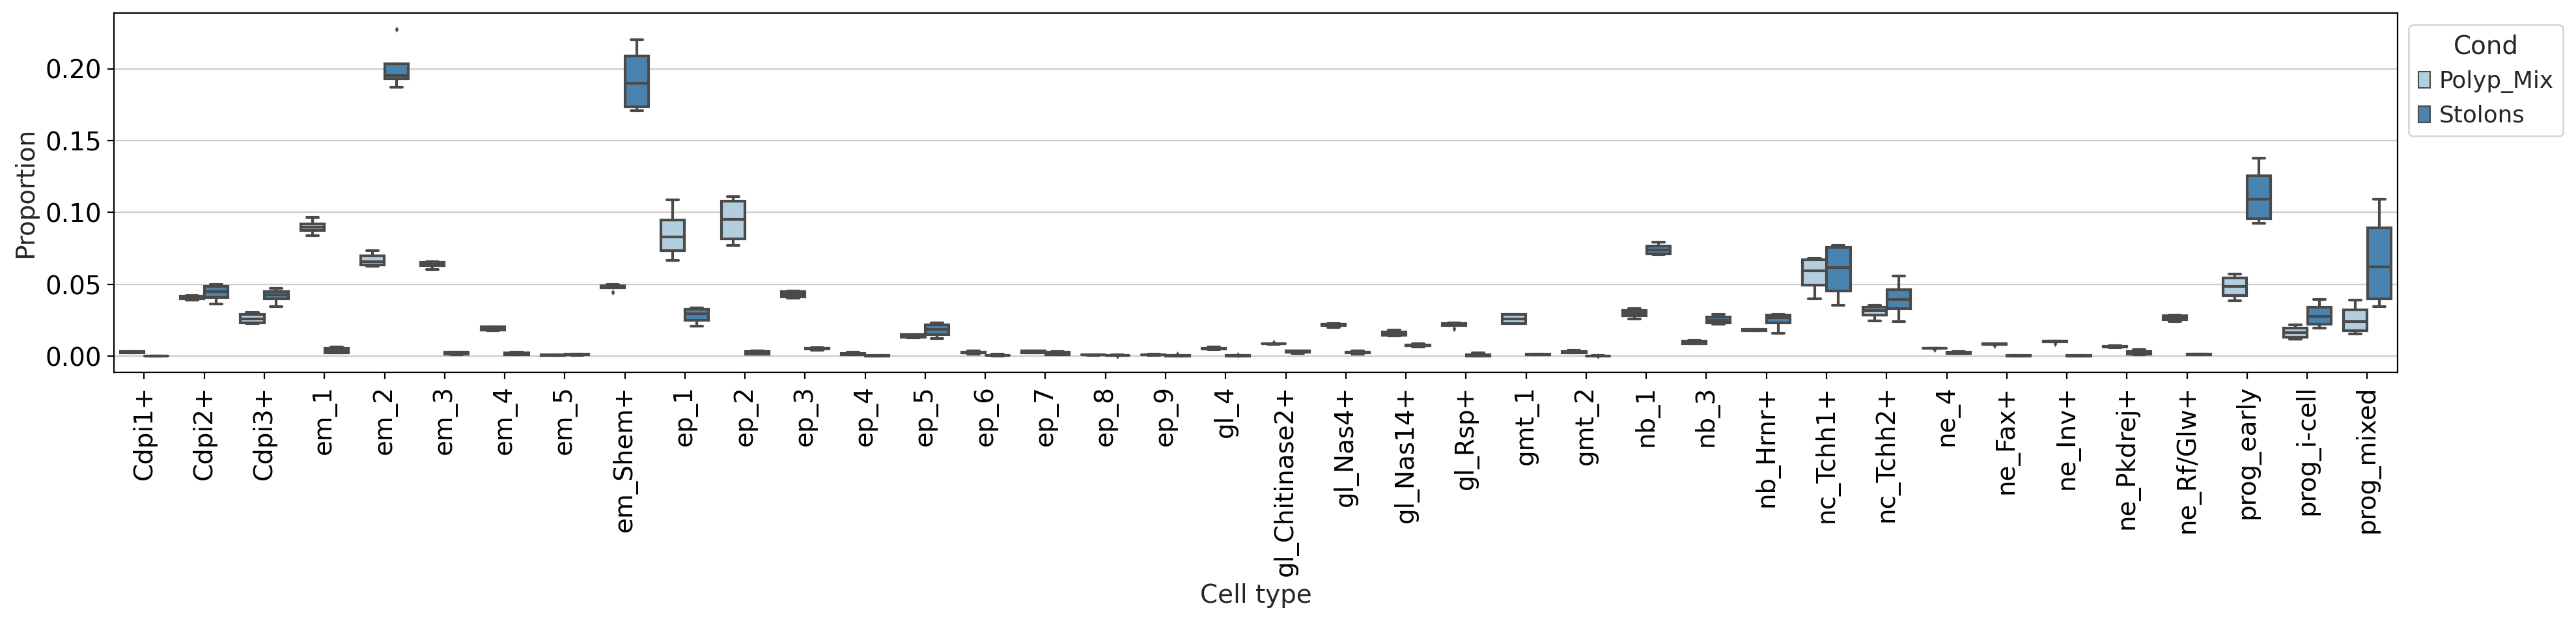

In [11]:
with plt.rc_context({'figure.figsize': (20, 5)}):
    viz.boxplots(comp_data_lib20, feature_name="Cond")
    plt.show()

In [12]:
model_lib20 = mod.CompositionalAnalysis(comp_data_lib20, formula="C(Cond, Treatment('Polyp_Mix'))", reference_cell_type='automatic')

Automatic reference selection! Reference cell type set to em_5
Zero counts encountered in data! Added a pseudocount of 0.5.


In [14]:
sim_results = model_lib20.sample_hmc()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:21<00:00, 99.06it/s]


MCMC sampling finished. (254.049 sec)
Acceptance rate: 83.0%


In [15]:
sim_results.summary()

Compositional Analysis summary:

Data: 8 samples, 38 cell types
Reference index: 7
Formula: C(Cond, Treatment('Polyp_Mix'))

Intercepts:
                Final Parameter  Expected Sample
Cell Type                                       
Cdpi1+                    1.232        24.382802
Cdpi2+                    3.827       326.646342
Cdpi3+                    3.504       236.483411
em_1                      4.659       750.603886
em_2                      4.365       559.407430
em_3                      4.316       532.657199
em_4                      3.117       160.593779
em_5                      0.207         8.748463
em_Shem+                  4.036       402.573651
ep_1                      4.588       699.158916
ep_2                      4.700       782.018239
ep_3                      3.922       359.199543
ep_4                      0.556        12.402252
ep_5                      2.849       122.839431
ep_6                      1.057        20.468315
ep_7                      1.13

In [16]:
sim_results.summary_extended()

Compositional Analysis summary (extended):

Data: 8 samples, 38 cell types
Reference index: 7
Formula: C(Cond, Treatment('Polyp_Mix'))
Spike-and-slab threshold: 0.625

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 254.049 sec. Acceptance rate: 83.0%

Intercepts:
                Final Parameter  HDI 3%  HDI 97%     SD  Expected Sample
Cell Type                                                               
Cdpi1+                    1.232   0.702    1.751  0.279        24.382802
Cdpi2+                    3.827   3.603    4.047  0.119       326.646342
Cdpi3+                    3.504   3.235    3.779  0.145       236.483411
em_1                      4.659   4.446    4.898  0.120       750.603886
em_2                      4.365   4.135    4.600  0.125       559.407430
em_3                      4.316   4.073    4.550  0.127       532.657199
em_4                      3.117   2.809    3.391  0.157       160.593779
em_5                      0.207  -0.354    0.739  0.299    

In [17]:
print(sim_results.credible_effects())

Covariate                                   Cell Type     
C(Cond, Treatment('Polyp_Mix'))[T.Stolons]  Cdpi1+             True
                                            Cdpi2+            False
                                            Cdpi3+            False
                                            em_1               True
                                            em_2               True
                                            em_3               True
                                            em_4               True
                                            em_5              False
                                            em_Shem+           True
                                            ep_1               True
                                            ep_2               True
                                            ep_3               True
                                            ep_4               True
                                            ep_5         

In [19]:
sim_results.set_fdr(est_fdr=0.01)
sim_results.summary()

Compositional Analysis summary:

Data: 8 samples, 38 cell types
Reference index: 7
Formula: C(Cond, Treatment('Polyp_Mix'))

Intercepts:
                Final Parameter  Expected Sample
Cell Type                                       
Cdpi1+                    1.232        24.382802
Cdpi2+                    3.827       326.646342
Cdpi3+                    3.504       236.483411
em_1                      4.659       750.603886
em_2                      4.365       559.407430
em_3                      4.316       532.657199
em_4                      3.117       160.593779
em_5                      0.207         8.748463
em_Shem+                  4.036       402.573651
ep_1                      4.588       699.158916
ep_2                      4.700       782.018239
ep_3                      3.922       359.199543
ep_4                      0.556        12.402252
ep_5                      2.849       122.839431
ep_6                      1.057        20.468315
ep_7                      1.13

In [22]:
print(sim_results.credible_effects())

Covariate                                   Cell Type     
C(Cond, Treatment('Polyp_Mix'))[T.Stolons]  Cdpi1+             True
                                            Cdpi2+            False
                                            Cdpi3+            False
                                            em_1               True
                                            em_2               True
                                            em_3               True
                                            em_4               True
                                            em_5              False
                                            em_Shem+           True
                                            ep_1               True
                                            ep_2               True
                                            ep_3               True
                                            ep_4              False
                                            ep_5         

In [24]:
sim_results.set_fdr(est_fdr= 0.005)
sim_results.summary()

Compositional Analysis summary:

Data: 8 samples, 38 cell types
Reference index: 7
Formula: C(Cond, Treatment('Polyp_Mix'))

Intercepts:
                Final Parameter  Expected Sample
Cell Type                                       
Cdpi1+                    1.232        24.382802
Cdpi2+                    3.827       326.646342
Cdpi3+                    3.504       236.483411
em_1                      4.659       750.603886
em_2                      4.365       559.407430
em_3                      4.316       532.657199
em_4                      3.117       160.593779
em_5                      0.207         8.748463
em_Shem+                  4.036       402.573651
ep_1                      4.588       699.158916
ep_2                      4.700       782.018239
ep_3                      3.922       359.199543
ep_4                      0.556        12.402252
ep_5                      2.849       122.839431
ep_6                      1.057        20.468315
ep_7                      1.13

In [25]:
print(sim_results.credible_effects())

Covariate                                   Cell Type     
C(Cond, Treatment('Polyp_Mix'))[T.Stolons]  Cdpi1+             True
                                            Cdpi2+            False
                                            Cdpi3+            False
                                            em_1               True
                                            em_2               True
                                            em_3               True
                                            em_4               True
                                            em_5              False
                                            em_Shem+           True
                                            ep_1               True
                                            ep_2               True
                                            ep_3               True
                                            ep_4              False
                                            ep_5         

In [26]:
sim_results.set_fdr(est_fdr= 0.0005)
sim_results.summary()

Compositional Analysis summary:

Data: 8 samples, 38 cell types
Reference index: 7
Formula: C(Cond, Treatment('Polyp_Mix'))

Intercepts:
                Final Parameter  Expected Sample
Cell Type                                       
Cdpi1+                    1.232        24.382802
Cdpi2+                    3.827       326.646342
Cdpi3+                    3.504       236.483411
em_1                      4.659       750.603886
em_2                      4.365       559.407430
em_3                      4.316       532.657199
em_4                      3.117       160.593779
em_5                      0.207         8.748463
em_Shem+                  4.036       402.573651
ep_1                      4.588       699.158916
ep_2                      4.700       782.018239
ep_3                      3.922       359.199543
ep_4                      0.556        12.402252
ep_5                      2.849       122.839431
ep_6                      1.057        20.468315
ep_7                      1.13

In [27]:
print(sim_results.credible_effects())

Covariate                                   Cell Type     
C(Cond, Treatment('Polyp_Mix'))[T.Stolons]  Cdpi1+             True
                                            Cdpi2+            False
                                            Cdpi3+            False
                                            em_1               True
                                            em_2               True
                                            em_3               True
                                            em_4               True
                                            em_5              False
                                            em_Shem+           True
                                            ep_1               True
                                            ep_2               True
                                            ep_3               True
                                            ep_4              False
                                            ep_5         

#### library 27 biological replicates

In [6]:
adata.obs

,Experiment,Library,Body_part,Presence_of_PEG,batch,n_counts,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden_1,leiden_1.5,leiden_2,Colony_part,Unique,leiden_1.5_names,broad_names
CTGTAGCCAAACATCGGACTAGTA-0-0,lib_29,lib_29_1,Polyps,PEG,3,52.0,50,50,52.0,0.0,0.0,0,0,13,Polyp_Sexual,lib_29_1_Polyps_Polyp_Sexual_PEG,ep_1,epithelial
CGAACTTACAAGACTAACAGATTC-0-0,lib_29,lib_29_1,Polyps,PEG,3,109.0,99,99,109.0,0.0,0.0,3,6,3,Polyp_Sexual,lib_29_1_Polyps_Polyp_Sexual_PEG,gmt_1,gametogenesis
AGAGTCAACGACACACGATAGACA-0-0,lib_29,lib_29_1,Polyps,PEG,3,124.0,107,107,124.0,0.0,0.0,2,4,4,Polyp_Sexual,lib_29_1_Polyps_Polyp_Sexual_PEG,prog_early,progenitors
CGCTGATCACGCTCGAAAGAGATC-0-0,lib_29,lib_29_1,Polyps,PEG,3,83.0,62,62,83.0,0.0,0.0,3,8,21,Polyp_Sexual,lib_29_1_Polyps_Polyp_Sexual_PEG,prog_mixed,progenitors
AAGACGGAGGAGAACACGAACTTA-0-0,lib_29,lib_29_1,Polyps,PEG,3,54.0,51,51,54.0,0.0,0.0,3,6,3,Polyp_Sexual,lib_29_1_Polyps_Polyp_Sexual_PEG,gmt_1,gametogenesis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAATGGAAGAATCTGAATAGCGAC-3-1,lib_20,lib_20_4,Polyps,PEG,1,74.0,70,70,74.0,0.0,0.0,0,0,0,Polyp_Mix,lib_20_4_Polyps_Polyp_Mix_PEG,ep_1,epithelial
AAGGTACACACCTTACCAGCGTTA-3-1,lib_20,lib_20_4,Polyps,PEG,1,58.0,52,52,58.0,0.0,0.0,6,15,19,Polyp_Mix,lib_20_4_Polyps_Polyp_Mix_PEG,nc_Tchh2+,nematocyte
GAATCTGAACAAGCTATGAAGAGA-3-1,lib_20,lib_20_4,Polyps,PEG,1,287.0,220,220,287.0,0.0,0.0,18,21,24,Polyp_Mix,lib_20_4_Polyps_Polyp_Mix_PEG,gl_Rsp+,gland
CTGGCATATGGCTTCACATACCAA-3-1,lib_20,lib_20_4,Polyps,PEG,1,326.0,255,255,326.0,0.0,0.0,12,11,11,Polyp_Mix,lib_20_4_Polyps_Polyp_Mix_PEG,em_Shem+,epitheliomuscular


In [7]:
lib27 = adata.obs['Experiment'].str.contains('lib_27', regex=True, case= False)
lib27_b = adata[lib27, :]
lib27_b.obs['Unique'].unique()

['lib_27_1_Polyps_Polyp_Feeding_PEG', 'lib_27_2_Polyps_Polyp_Feeding_PEG']
Categories (2, object): ['lib_27_1_Polyps_Polyp_Feeding_PEG', 'lib_27_2_Polyps_Polyp_Feeding_PEG']

In [9]:
library27_1_cells = (lib27_b.obs['Colony_part'].str.contains('Polyp_Feeding', regex=True, case= False)) & (lib27_b.obs['Library'].str.contains('lib_27_1'))
library27_2_cells = (lib27_b.obs['Colony_part'].str.contains('Polyp_Feeding', regex=True, case= False)) & (lib27_b.obs['Library'].str.contains('lib_27_2'))

lib27_b.obs.loc[library27_1_cells,'sample']= '27_1_f'
lib27_b.obs.loc[library27_2_cells,'sample']= '27_2_f'

In [12]:
cov_df = pd.DataFrame({"Cond":["lib_27_1","lib_27_2"]}, 
                      index=["27_1_f","27_2_f"])
print(cov_df)

            Cond
27_1_f  lib_27_1
27_2_f  lib_27_2


In [13]:
comp_data_lib27 = sccoda.util.cell_composition_data.from_scanpy(lib27_b, 
                                                                    cell_type_identifier='leiden_1.5_names', 
                                                                    sample_identifier='sample',
                                                                    covariate_df= cov_df)

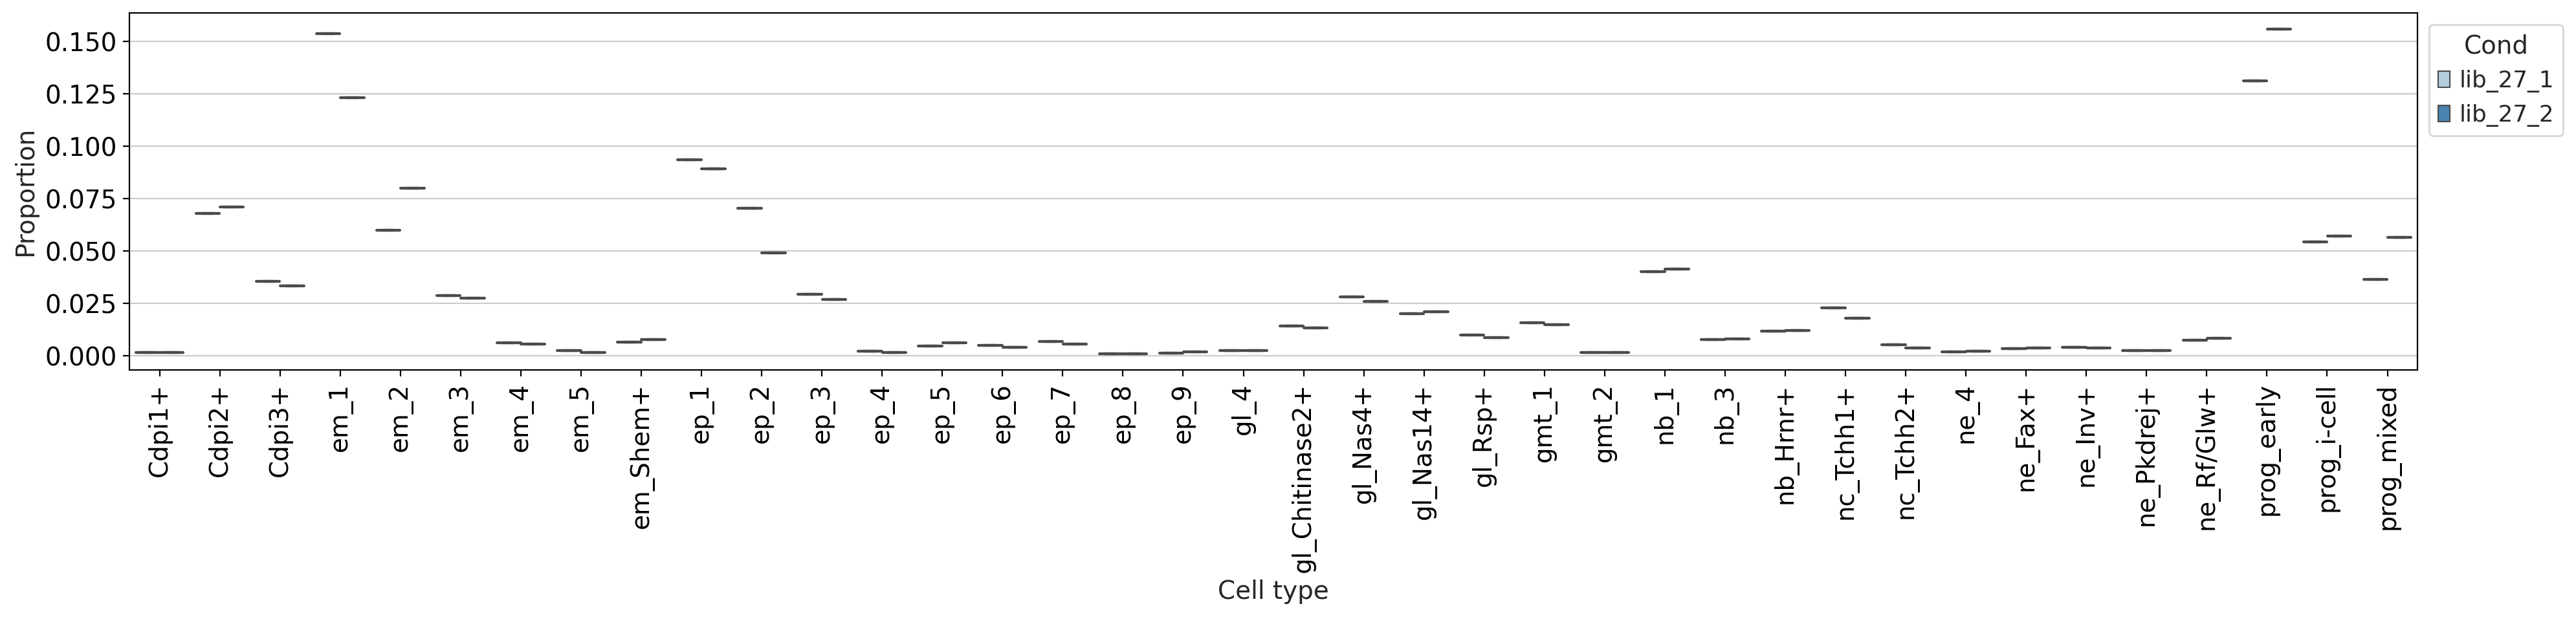

In [14]:
with plt.rc_context({'figure.figsize': (20, 5)}):
    viz.boxplots(comp_data_lib27, feature_name="Cond")
    plt.show()

In [15]:
model_lib27 = mod.CompositionalAnalysis(comp_data_lib27, formula="C(Cond, Treatment('lib_27_1'))", reference_cell_type='automatic')

Automatic reference selection! Reference cell type set to ne_Pkdrej+


In [16]:
sim_results = model_lib27.sample_hmc()

  0%|                                                                                                        | 0/20000 [00:00<?, ?it/s]2023-10-22 16:36:57.089026: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7424009230 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-10-22 16:36:57.089082: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-10-22 16:36:57.139373: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-22 16:36:57.674177: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|███████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:20<00:00, 142.60it/s]


MCMC sampling finished. (176.816 sec)
Acceptance rate: 55.5%


In [17]:
sim_results.summary()

Compositional Analysis summary:

Data: 2 samples, 38 cell types
Reference index: 33
Formula: C(Cond, Treatment('lib_27_1'))

Intercepts:
                Final Parameter  Expected Sample
Cell Type                                       
Cdpi1+                    2.112        23.442113
Cdpi2+                    5.875      1009.826790
Cdpi3+                    5.188       508.026748
em_1                      6.655      2202.909136
em_2                      5.772       910.991986
em_3                      4.979       412.210483
em_4                      3.416        86.360820
em_5                      2.338        29.386462
em_Shem+                  3.593       103.082960
ep_1                      6.162      1345.517667
ep_2                      5.856       990.821206
ep_3                      4.981       413.035729
ep_4                      2.314        28.689583
ep_5                      3.311        77.752764
ep_6                      3.149        66.124154
ep_7                      3.49

In [18]:
sim_results.summary_extended()

Compositional Analysis summary (extended):

Data: 2 samples, 38 cell types
Reference index: 33
Formula: C(Cond, Treatment('lib_27_1'))
Spike-and-slab threshold: 0.934

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 176.816 sec. Acceptance rate: 55.5%

Intercepts:
                Final Parameter  HDI 3%  HDI 97%     SD  Expected Sample
Cell Type                                                               
Cdpi1+                    2.112   1.095    3.098  0.555        23.442113
Cdpi2+                    5.875   5.057    6.803  0.483      1009.826790
Cdpi3+                    5.188   4.347    6.099  0.488       508.026748
em_1                      6.655   5.785    7.530  0.490      2202.909136
em_2                      5.772   4.977    6.621  0.464       910.991986
em_3                      4.979   4.083    5.867  0.490       412.210483
em_4                      3.416   2.484    4.358  0.515        86.360820
em_5                      2.338   1.288    3.321  0.555    

In [19]:
print(sim_results.credible_effects())

Covariate                                   Cell Type     
C(Cond, Treatment('lib_27_1'))[T.lib_27_2]  Cdpi1+            False
                                            Cdpi2+            False
                                            Cdpi3+            False
                                            em_1               True
                                            em_2              False
                                            em_3              False
                                            em_4              False
                                            em_5              False
                                            em_Shem+          False
                                            ep_1              False
                                            ep_2               True
                                            ep_3              False
                                            ep_4              False
                                            ep_5         

#### library 29 biological replicates

In [22]:
lib29 = adata.obs['Experiment'].str.contains('lib_29', regex=True, case= False)
lib29_b = adata[lib29, :]
lib29_b.obs['Unique'].unique()

['lib_29_1_Polyps_Polyp_Sexual_PEG', 'lib_29_2_Polyps_Polyp_Sexual_PEG']
Categories (2, object): ['lib_29_1_Polyps_Polyp_Sexual_PEG', 'lib_29_2_Polyps_Polyp_Sexual_PEG']

In [24]:
library29_1_cells = (lib29_b.obs['Colony_part'].str.contains('Polyp_Sexual', regex=True, case= False)) & (lib29_b.obs['Library'].str.contains('lib_29_1'))
library29_2_cells = (lib29_b.obs['Colony_part'].str.contains('Polyp_Sexual', regex=True, case= False)) & (lib29_b.obs['Library'].str.contains('lib_29_2'))

lib29_b.obs.loc[library29_1_cells,'sample']= '29_1_s'
lib29_b.obs.loc[library29_2_cells,'sample']= '29_2_s'

In [27]:
cov_df = pd.DataFrame({"Cond":["lib_29_1","lib_29_2"]}, 
                      index=["29_1_s","29_2_s"])
print(cov_df)

            Cond
29_1_s  lib_29_1
29_2_s  lib_29_2


In [28]:
comp_data_lib29 = sccoda.util.cell_composition_data.from_scanpy(lib29_b, 
                                                                    cell_type_identifier='leiden_1.5_names', 
                                                                    sample_identifier='sample',
                                                                    covariate_df= cov_df)

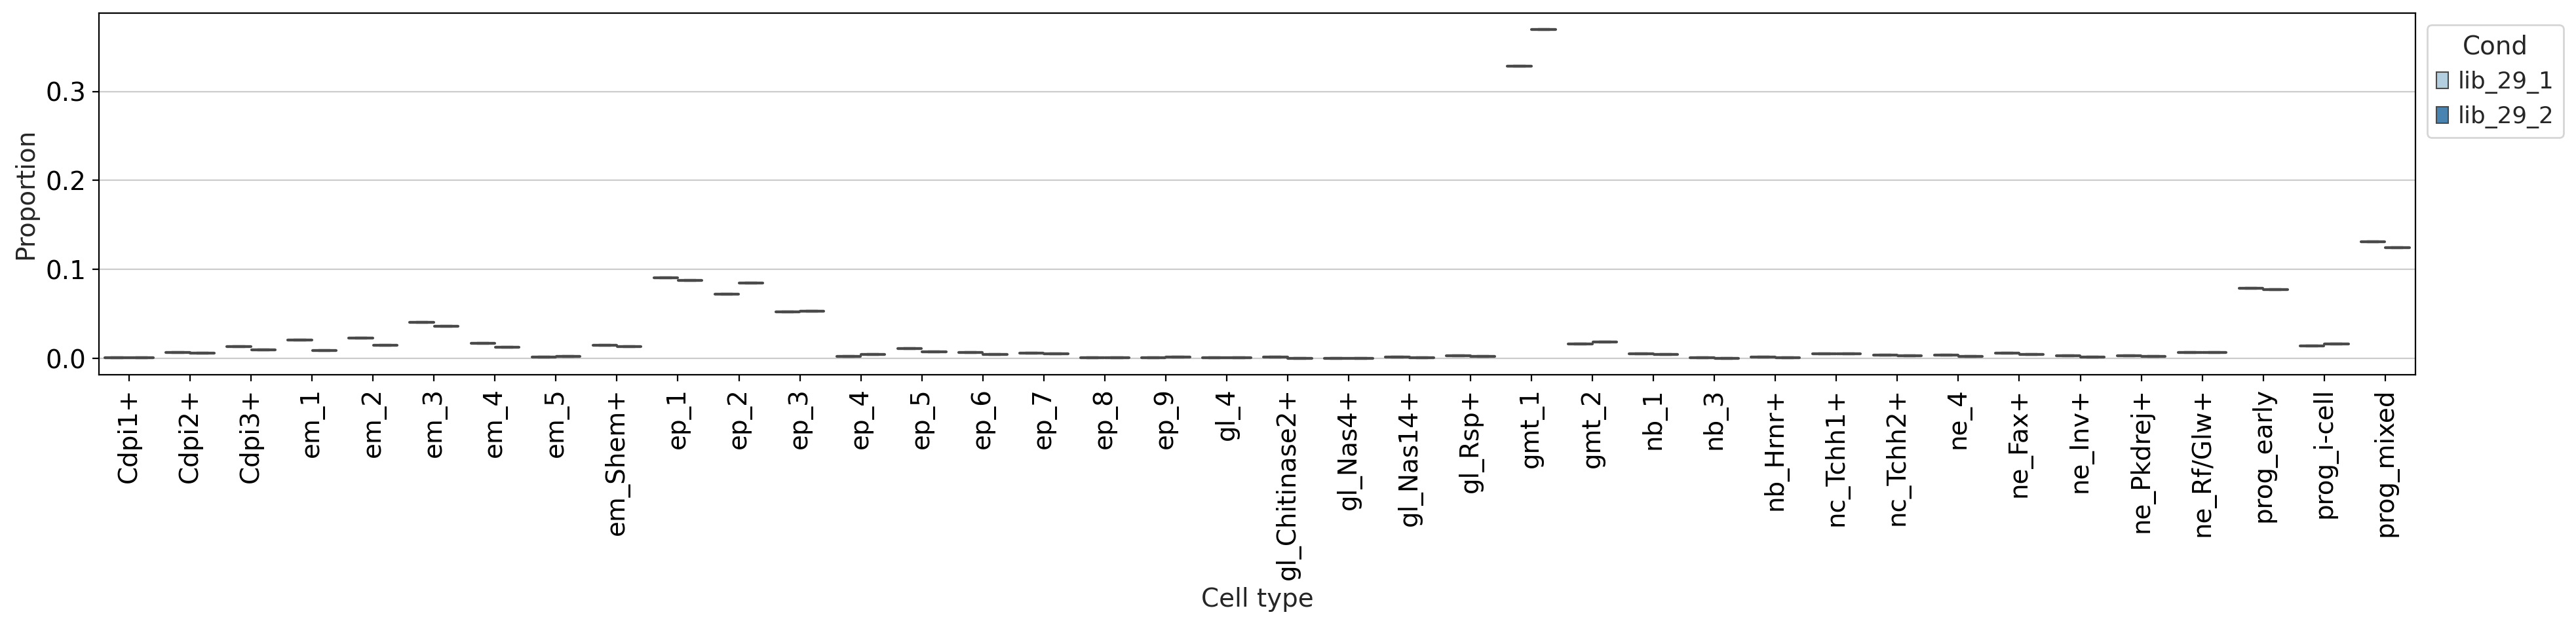

In [29]:
with plt.rc_context({'figure.figsize': (20, 5)}):
    viz.boxplots(comp_data_lib29, feature_name="Cond")
    plt.show()

In [30]:
model_lib29 = mod.CompositionalAnalysis(comp_data_lib29, formula="C(Cond, Treatment('lib_29_1'))", reference_cell_type='automatic')

Automatic reference selection! Reference cell type set to ep_3


In [31]:
sim_results = model_lib29.sample_hmc()

100%|███████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:16<00:00, 146.86it/s]


MCMC sampling finished. (173.165 sec)
Acceptance rate: 57.1%


In [32]:
sim_results.summary()

Compositional Analysis summary:

Data: 2 samples, 38 cell types
Reference index: 11
Formula: C(Cond, Treatment('lib_29_1'))

Intercepts:
                Final Parameter  Expected Sample
Cell Type                                       
Cdpi1+                    1.031         9.073418
Cdpi2+                    3.044        67.921257
Cdpi3+                    3.669       126.893614
em_1                      4.013       178.993420
em_2                      4.191       213.865871
em_3                      4.869       421.301634
em_4                      3.919       162.934625
em_5                      1.693        17.590325
em_Shem+                  3.853       152.528131
ep_1                      5.699       966.178933
ep_2                      5.509       798.990493
ep_3                      5.185       577.870068
ep_4                      2.340        33.594053
ep_5                      3.449       101.834510
ep_6                      2.967        62.887603
ep_7                      2.94

In [33]:
sim_results.summary_extended()

Compositional Analysis summary (extended):

Data: 2 samples, 38 cell types
Reference index: 11
Formula: C(Cond, Treatment('lib_29_1'))
Spike-and-slab threshold: 1.000

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 173.165 sec. Acceptance rate: 57.1%

Intercepts:
                Final Parameter  HDI 3%  HDI 97%     SD  Expected Sample
Cell Type                                                               
Cdpi1+                    1.031  -0.309    2.111  0.648         9.073418
Cdpi2+                    3.044   2.246    3.925  0.446        67.921257
Cdpi3+                    3.669   2.931    4.558  0.433       126.893614
em_1                      4.013   3.146    4.954  0.492       178.993420
em_2                      4.191   3.417    4.989  0.432       213.865871
em_3                      4.869   4.155    5.650  0.401       421.301634
em_4                      3.919   3.182    4.761  0.424       162.934625
em_5                      1.693   0.666    2.682  0.558    

In [34]:
print(sim_results.credible_effects())

Covariate                                   Cell Type     
C(Cond, Treatment('lib_29_1'))[T.lib_29_2]  Cdpi1+            False
                                            Cdpi2+            False
                                            Cdpi3+            False
                                            em_1              False
                                            em_2              False
                                            em_3              False
                                            em_4              False
                                            em_5              False
                                            em_Shem+          False
                                            ep_1              False
                                            ep_2              False
                                            ep_3              False
                                            ep_4              False
                                            ep_5         